# Probability maps animation

This notebook creates an animation showing the evolution of the predicted time-dependent deposit probability from 170Ma-present. The notebook `02-create_probability_maps.ipynb` must have been run previously.

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

## Notebook options

These cells set some of the important variables and definitions used throughout the notebook.

### Select plate model

To use the plate model from the published paper (Alfonso et al., 2024), set `use_provided_plate_model` to `True`. Otherwise, leave `use_provided_plate_model` as `False` and set `plate_model_name` to a valid model name for the [`plate-model-manager`](https://github.com/michaelchin/plate-model-manager/blob/4f66423b53950bf42f5dac1228e61fd1e19fdf6e/models.json) package, or set `plate_model_name` to `None` and place GPlates files in a directory named `plate_model`.

| `use_provided_plate_model` | `plate_model_name` | result |
| - | - | - |
| `True` | Any | Use Alfonso et al., 2024 model |
| `False` | Model name string (e.g. `"muller2022"`) | Use specified plate model |
| `False` | `None` | Use files in `plate_model` directory |

In [1]:
use_provided_plate_model = True
plate_model_name = "muller2022"

### Set other parameters

In [2]:
# If True, use training data extracted in notebook 00c
# Else, use pre-prepared training data downloaded from Zenodo
use_extracted_data = True

# Number of processes to use
n_jobs = 4

# Overwrite any existing output files
overwrite = True

# Timespan for analysis
start_time = 0
end_time = 170

# Control verbosity level of logging output
verbose = False

These values will usually not need to be modified:

In [3]:
from lib.check_files import check_prepared_data

if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = check_prepared_data("prepared_data", verbose=True)

output_dir = "outputs"

If any of the following exist as environment variables, they will replace the values defined above:

In [4]:
import os

n_jobs = int(os.environ.get("N_JOBS", n_jobs))
overwrite = bool(int(os.environ.get("OVERWRITE", overwrite)))
start_time = int(os.environ.get("START_TIME", start_time))
end_time = int(os.environ.get("END_TIME", end_time))
verbose = bool(int(os.environ.get("VERBOSE", verbose)))
output_dir = os.environ.get("OUTPUT_DIR", output_dir)

times = range(start_time, end_time + 1)

## Notebook setup

Imports, definitions, etc.

### Imports

In [5]:
import glob
import tempfile

import cartopy.crs as ccrs
import pandas as pd
import pygplates
from gplately import (
    PlateReconstruction,
    PlotTopologies,
)
from joblib import Parallel, delayed

from lib.animation import create_animation
from lib.check_files import (
    check_plate_model,
)
from lib.misc import (
    filter_topological_features,
    reconstruct_by_topologies,
)
from lib.plate_models import (
    get_plate_reconstruction,
    get_plot_topologies,
)
from lib.visualisation import plot

# Suppress occasional joblib warnings
%env PYTHONWARNINGS=ignore::UserWarning

NOTEBOOK = "get_ipython" in dir()

env: PYTHONWARNINGS=ignore::UserWarning


### Input and output files

If necessary, the plate model will be downloaded:

In [6]:
plate_model_dir = "plate_model"
if use_provided_plate_model:
    check_plate_model(plate_model_dir, verbose=True)
    plate_model_name = None
plate_model, _tf = get_plate_reconstruction(
    model_name=plate_model_name,
    model_dir=plate_model_dir,
    filter_topologies=True,
)

if use_provided_plate_model:
    coastlines_filenames = [os.path.join(
        plate_model_dir,
        "StaticGeometries",
        "AgeGridInput",
        "CombinedTerranes.gpml",
    )]
    gplot = PlotTopologies(
        plate_model,
        coastlines=coastlines_filenames,
    )
else:
    gplot = get_plot_topologies(
        model_name=plate_model_name,
        model_dir=plate_model_dir,
        plate_reconstruction=plate_model,
        filter_topologies=True,
    )

output_dir = os.path.join(output_dir, "global")

downloading https://repo.gplates.org/webdav/pmm/muller2022/Rotations.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2022/Topologies.zip


The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2022/StaticPolygons.zip


The local file(s) is/are still good. Will not download again at this moment.


downloading https://repo.gplates.org/webdav/pmm/muller2022/Coastlines.zip


### Plot options

These should generally be left unchanged.

In [7]:
lon_0 = 0.0
projection = ccrs.Mollweide(lon_0)

imshow_kwargs = dict(
    vmin=0,
    vmax=60,
    cmap="viridis"
)

### Load training data

The training dataset is used to plot deposit locations on the maps.

In [8]:
training_filename = os.path.join(data_dir, "training_data_global.csv")
training_data = pd.read_csv(training_filename)
positives = training_data[training_data["label"] == "positive"]

### Reconstruct deposit data for plots

In [9]:
positives = reconstruct_by_topologies(
    data=(positives[["lon", "lat", "age (Ma)", "label"]]).copy(),
    plate_reconstruction=plate_model,
    times=times,
)

## Example plot

Create an example plot at a single time step (by default, 110 Ma).

PU example plot:


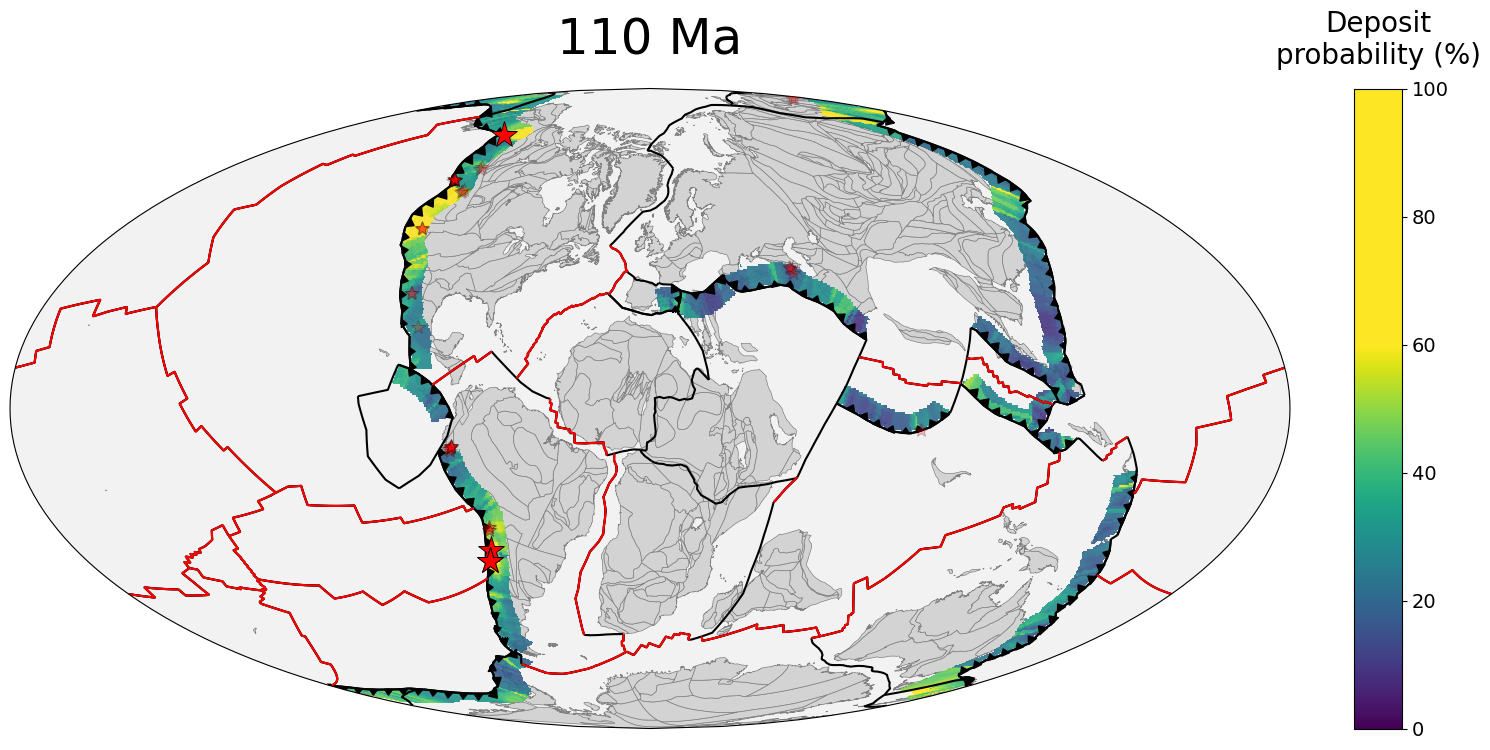

In [10]:
# Example plot (only in notebook)
if NOTEBOOK:
    t_example = 110  # Ma
    gplot.time = t_example
    algorithm = "PU"
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    print(f"{algorithm} example plot:")
    fig = plot(
        gplot=gplot,
        probabilities=os.path.join(
            probs_dir,
            f"probability_grid_{t_example:0.0f}Ma.nc",
        ),
        positives=positives,
        projection=projection,
        time=t_example,
        central_meridian=lon_0,
        imshow_kwargs=imshow_kwargs,
    )

## Create all plots

This will create the plots for all models.

In [11]:
for algorithm in ("PU", "SVM"):
    output_filename = os.path.join(
        output_dir,
        algorithm,
        "probability_animation.mp4",
    )
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    # Create all plots
    with tempfile.TemporaryDirectory() as tmpdir, \
            Parallel(n_jobs=n_jobs, verbose=int(verbose)) as parallel:

        output_filenames = [
            os.path.join(tmpdir, f"image_{t:0.0f}Ma.png")
            for t in times
        ]
        parallel(
            delayed(plot)(
                gplot=gplot,
                probabilities=os.path.join(
                    probs_dir,
                    f"probability_grid_{t:0.0f}Ma.nc",
                ),
                projection=projection,
                time=t,
                positives=positives,
                output_filename=o,
                central_meridian=lon_0,
                imshow_kwargs=imshow_kwargs,
            )
            for t, o in zip(times, output_filenames)
        )
        create_animation(
            image_filenames=output_filenames[::-1],  # reverse order of frames (forward in time)
            output_filename=output_filename,
            fps=10,  # framerate of output video
            bitrate="5000k",
        )

Moviepy - Building video outputs_new/global/PU/probability_animation.mp4.
Moviepy - Writing video outputs_new/global/PU/probability_animation.mp4




t:   0%|                                                                                                                                      | 0/513 [00:00<?, ?it/s, now=None]


t:   0%|▍                                                                                                                             | 2/513 [00:00<00:40, 12.59it/s, now=None]


t:   1%|▉                                                                                                                             | 4/513 [00:00<00:50, 10.01it/s, now=None]


t:   1%|█▍                                                                                                                            | 6/513 [00:00<01:12,  6.97it/s, now=None]


t:   1%|█▋                                                                                                                            | 7/513 [00:00<01:08,  7.43it/s, now=None]


t:   2%|█▉                                                                                                                            | 8/513 [00:01<01:22,  6.12it/s, now=None]


t:   2%|██▏                                                                                                                           | 9/513 [00:01<01:14,  6.76it/s, now=None]


t:   2%|██▍                                                                                                                          | 10/513 [00:01<01:08,  7.32it/s, now=None]


t:   2%|██▋                                                                                                                          | 11/513 [00:01<01:23,  6.01it/s, now=None]


t:   2%|██▉                                                                                                                          | 12/513 [00:01<01:16,  6.53it/s, now=None]


t:   3%|███▏                                                                                                                         | 13/513 [00:01<01:09,  7.16it/s, now=None]


t:   3%|███▍                                                                                                                         | 14/513 [00:02<01:25,  5.84it/s, now=None]


t:   3%|███▋                                                                                                                         | 15/513 [00:02<01:18,  6.37it/s, now=None]


t:   3%|███▉                                                                                                                         | 16/513 [00:02<01:11,  6.98it/s, now=None]


t:   3%|████▏                                                                                                                        | 17/513 [00:02<01:24,  5.87it/s, now=None]


t:   4%|████▍                                                                                                                        | 18/513 [00:02<01:17,  6.41it/s, now=None]


t:   4%|████▋                                                                                                                        | 19/513 [00:02<01:10,  7.03it/s, now=None]


t:   4%|████▊                                                                                                                        | 20/513 [00:02<01:22,  5.94it/s, now=None]


t:   4%|█████                                                                                                                        | 21/513 [00:03<01:13,  6.70it/s, now=None]


t:   4%|█████▎                                                                                                                       | 22/513 [00:03<01:06,  7.36it/s, now=None]


t:   4%|█████▌                                                                                                                       | 23/513 [00:03<01:20,  6.11it/s, now=None]


t:   5%|█████▊                                                                                                                       | 24/513 [00:03<01:11,  6.82it/s, now=None]


t:   5%|██████                                                                                                                       | 25/513 [00:03<01:07,  7.21it/s, now=None]


t:   5%|██████▎                                                                                                                      | 26/513 [00:03<01:23,  5.86it/s, now=None]


t:   5%|██████▌                                                                                                                      | 27/513 [00:04<01:13,  6.61it/s, now=None]


t:   5%|██████▊                                                                                                                      | 28/513 [00:04<01:06,  7.26it/s, now=None]


t:   6%|███████                                                                                                                      | 29/513 [00:04<01:20,  5.98it/s, now=None]


t:   6%|███████▎                                                                                                                     | 30/513 [00:04<01:11,  6.71it/s, now=None]


t:   6%|███████▌                                                                                                                     | 31/513 [00:04<01:05,  7.31it/s, now=None]


t:   6%|███████▊                                                                                                                     | 32/513 [00:04<01:23,  5.77it/s, now=None]


t:   6%|████████                                                                                                                     | 33/513 [00:04<01:13,  6.54it/s, now=None]


t:   7%|████████▎                                                                                                                    | 34/513 [00:05<01:06,  7.19it/s, now=None]


t:   7%|████████▌                                                                                                                    | 35/513 [00:05<01:20,  5.92it/s, now=None]


t:   7%|████████▊                                                                                                                    | 36/513 [00:05<01:13,  6.51it/s, now=None]


t:   7%|█████████                                                                                                                    | 37/513 [00:05<01:08,  6.97it/s, now=None]


t:   7%|█████████▎                                                                                                                   | 38/513 [00:05<01:23,  5.68it/s, now=None]


t:   8%|█████████▌                                                                                                                   | 39/513 [00:05<01:14,  6.32it/s, now=None]


t:   8%|█████████▋                                                                                                                   | 40/513 [00:05<01:08,  6.92it/s, now=None]


t:   8%|█████████▉                                                                                                                   | 41/513 [00:06<01:20,  5.84it/s, now=None]


t:   8%|██████████▏                                                                                                                  | 42/513 [00:06<01:11,  6.59it/s, now=None]


t:   8%|██████████▍                                                                                                                  | 43/513 [00:06<01:05,  7.17it/s, now=None]


t:   9%|██████████▋                                                                                                                  | 44/513 [00:06<01:25,  5.50it/s, now=None]


t:   9%|██████████▉                                                                                                                  | 45/513 [00:06<01:17,  6.06it/s, now=None]


t:   9%|███████████▏                                                                                                                 | 46/513 [00:06<01:10,  6.64it/s, now=None]


t:   9%|███████████▍                                                                                                                 | 47/513 [00:07<01:23,  5.58it/s, now=None]


t:   9%|███████████▋                                                                                                                 | 48/513 [00:07<01:15,  6.20it/s, now=None]


t:  10%|███████████▉                                                                                                                 | 49/513 [00:07<01:11,  6.46it/s, now=None]


t:  10%|████████████▏                                                                                                                | 50/513 [00:07<01:27,  5.27it/s, now=None]


t:  10%|████████████▍                                                                                                                | 51/513 [00:07<01:18,  5.90it/s, now=None]


t:  10%|████████████▋                                                                                                                | 52/513 [00:07<01:12,  6.38it/s, now=None]


t:  10%|████████████▉                                                                                                                | 53/513 [00:08<01:24,  5.43it/s, now=None]


t:  11%|█████████████▏                                                                                                               | 54/513 [00:08<01:16,  5.97it/s, now=None]


t:  11%|█████████████▍                                                                                                               | 55/513 [00:08<01:09,  6.58it/s, now=None]


t:  11%|█████████████▋                                                                                                               | 56/513 [00:08<01:22,  5.53it/s, now=None]


t:  11%|█████████████▉                                                                                                               | 57/513 [00:08<01:13,  6.20it/s, now=None]


t:  11%|██████████████▏                                                                                                              | 58/513 [00:08<01:07,  6.74it/s, now=None]


t:  12%|██████████████▍                                                                                                              | 59/513 [00:09<01:21,  5.56it/s, now=None]


t:  12%|██████████████▌                                                                                                              | 60/513 [00:09<01:12,  6.22it/s, now=None]


t:  12%|██████████████▊                                                                                                              | 61/513 [00:09<01:07,  6.73it/s, now=None]


t:  12%|███████████████                                                                                                              | 62/513 [00:09<01:21,  5.55it/s, now=None]


t:  12%|███████████████▎                                                                                                             | 63/513 [00:09<01:12,  6.19it/s, now=None]


t:  12%|███████████████▌                                                                                                             | 64/513 [00:09<01:05,  6.82it/s, now=None]


t:  13%|███████████████▊                                                                                                             | 65/513 [00:10<01:18,  5.74it/s, now=None]


t:  13%|████████████████                                                                                                             | 66/513 [00:10<01:08,  6.48it/s, now=None]


t:  13%|████████████████▎                                                                                                            | 67/513 [00:10<01:03,  7.02it/s, now=None]


t:  13%|████████████████▌                                                                                                            | 68/513 [00:10<01:19,  5.61it/s, now=None]


t:  13%|████████████████▊                                                                                                            | 69/513 [00:10<01:10,  6.31it/s, now=None]


t:  14%|█████████████████                                                                                                            | 70/513 [00:10<01:04,  6.88it/s, now=None]


t:  14%|█████████████████▎                                                                                                           | 71/513 [00:11<01:17,  5.68it/s, now=None]


t:  14%|█████████████████▌                                                                                                           | 72/513 [00:11<01:09,  6.38it/s, now=None]


t:  14%|█████████████████▊                                                                                                           | 73/513 [00:11<01:03,  6.95it/s, now=None]


t:  14%|██████████████████                                                                                                           | 74/513 [00:11<01:16,  5.73it/s, now=None]


t:  15%|██████████████████▎                                                                                                          | 75/513 [00:11<01:09,  6.32it/s, now=None]


t:  15%|██████████████████▌                                                                                                          | 76/513 [00:11<01:02,  7.01it/s, now=None]


t:  15%|██████████████████▊                                                                                                          | 77/513 [00:12<01:15,  5.77it/s, now=None]


t:  15%|███████████████████                                                                                                          | 78/513 [00:12<01:06,  6.53it/s, now=None]


t:  15%|███████████████████▏                                                                                                         | 79/513 [00:12<01:00,  7.15it/s, now=None]


t:  16%|███████████████████▍                                                                                                         | 80/513 [00:12<01:13,  5.87it/s, now=None]


t:  16%|███████████████████▋                                                                                                         | 81/513 [00:12<01:08,  6.31it/s, now=None]


t:  16%|███████████████████▉                                                                                                         | 82/513 [00:12<01:02,  6.93it/s, now=None]


t:  16%|████████████████████▏                                                                                                        | 83/513 [00:13<01:14,  5.75it/s, now=None]


t:  16%|████████████████████▍                                                                                                        | 84/513 [00:13<01:05,  6.52it/s, now=None]


t:  17%|████████████████████▋                                                                                                        | 85/513 [00:13<01:00,  7.08it/s, now=None]


t:  17%|████████████████████▉                                                                                                        | 86/513 [00:13<01:12,  5.89it/s, now=None]


t:  17%|█████████████████████▏                                                                                                       | 87/513 [00:13<01:04,  6.59it/s, now=None]


t:  17%|█████████████████████▍                                                                                                       | 88/513 [00:13<01:00,  7.01it/s, now=None]


t:  17%|█████████████████████▋                                                                                                       | 89/513 [00:13<01:12,  5.85it/s, now=None]


t:  18%|█████████████████████▉                                                                                                       | 90/513 [00:14<01:04,  6.57it/s, now=None]


t:  18%|██████████████████████▏                                                                                                      | 91/513 [00:14<00:58,  7.18it/s, now=None]


t:  18%|██████████████████████▍                                                                                                      | 92/513 [00:14<01:11,  5.91it/s, now=None]


t:  18%|██████████████████████▋                                                                                                      | 93/513 [00:14<01:04,  6.56it/s, now=None]


t:  18%|██████████████████████▉                                                                                                      | 94/513 [00:14<00:59,  7.07it/s, now=None]


t:  19%|███████████████████████▏                                                                                                     | 95/513 [00:14<01:12,  5.78it/s, now=None]


t:  19%|███████████████████████▍                                                                                                     | 96/513 [00:14<01:03,  6.52it/s, now=None]


t:  19%|███████████████████████▋                                                                                                     | 97/513 [00:15<00:58,  7.09it/s, now=None]


t:  19%|███████████████████████▉                                                                                                     | 98/513 [00:15<01:10,  5.90it/s, now=None]


t:  19%|████████████████████████                                                                                                     | 99/513 [00:15<01:02,  6.65it/s, now=None]


t:  19%|████████████████████████▏                                                                                                   | 100/513 [00:15<00:57,  7.22it/s, now=None]


t:  20%|████████████████████████▍                                                                                                   | 101/513 [00:15<01:11,  5.78it/s, now=None]


t:  20%|████████████████████████▋                                                                                                   | 102/513 [00:15<01:02,  6.53it/s, now=None]


t:  20%|████████████████████████▉                                                                                                   | 103/513 [00:16<00:57,  7.11it/s, now=None]


t:  20%|█████████████████████████▏                                                                                                  | 104/513 [00:16<01:09,  5.85it/s, now=None]


t:  20%|█████████████████████████▍                                                                                                  | 105/513 [00:16<01:02,  6.52it/s, now=None]


t:  21%|█████████████████████████▌                                                                                                  | 106/513 [00:16<00:57,  7.13it/s, now=None]


t:  21%|█████████████████████████▊                                                                                                  | 107/513 [00:16<01:09,  5.82it/s, now=None]


t:  21%|██████████████████████████                                                                                                  | 108/513 [00:16<01:01,  6.57it/s, now=None]


t:  21%|██████████████████████████▎                                                                                                 | 109/513 [00:16<00:56,  7.11it/s, now=None]


t:  21%|██████████████████████████▌                                                                                                 | 110/513 [00:17<01:08,  5.88it/s, now=None]


t:  22%|██████████████████████████▊                                                                                                 | 111/513 [00:17<01:01,  6.58it/s, now=None]


t:  22%|███████████████████████████                                                                                                 | 112/513 [00:17<00:56,  7.12it/s, now=None]


t:  22%|███████████████████████████▎                                                                                                | 113/513 [00:17<01:10,  5.71it/s, now=None]


t:  22%|███████████████████████████▌                                                                                                | 114/513 [00:17<01:02,  6.42it/s, now=None]


t:  22%|███████████████████████████▊                                                                                                | 115/513 [00:17<00:56,  7.04it/s, now=None]


t:  23%|████████████████████████████                                                                                                | 116/513 [00:18<01:08,  5.82it/s, now=None]


t:  23%|████████████████████████████▎                                                                                               | 117/513 [00:18<01:00,  6.50it/s, now=None]


t:  23%|████████████████████████████▌                                                                                               | 118/513 [00:18<00:55,  7.13it/s, now=None]


t:  23%|████████████████████████████▊                                                                                               | 119/513 [00:18<01:07,  5.87it/s, now=None]


t:  23%|█████████████████████████████                                                                                               | 120/513 [00:18<01:02,  6.33it/s, now=None]


t:  24%|█████████████████████████████▏                                                                                              | 121/513 [00:18<00:56,  6.93it/s, now=None]


t:  24%|█████████████████████████████▍                                                                                              | 122/513 [00:19<01:07,  5.82it/s, now=None]


t:  24%|█████████████████████████████▋                                                                                              | 123/513 [00:19<00:59,  6.55it/s, now=None]


t:  24%|█████████████████████████████▉                                                                                              | 124/513 [00:19<00:54,  7.17it/s, now=None]


t:  24%|██████████████████████████████▏                                                                                             | 125/513 [00:19<01:05,  5.92it/s, now=None]


t:  25%|██████████████████████████████▍                                                                                             | 126/513 [00:19<00:59,  6.55it/s, now=None]


t:  25%|██████████████████████████████▋                                                                                             | 127/513 [00:19<00:54,  7.03it/s, now=None]


t:  25%|██████████████████████████████▉                                                                                             | 128/513 [00:19<01:06,  5.80it/s, now=None]


t:  25%|███████████████████████████████▏                                                                                            | 129/513 [00:20<00:59,  6.50it/s, now=None]


t:  25%|███████████████████████████████▍                                                                                            | 130/513 [00:20<00:53,  7.12it/s, now=None]


t:  26%|███████████████████████████████▋                                                                                            | 131/513 [00:20<01:05,  5.86it/s, now=None]


t:  26%|███████████████████████████████▉                                                                                            | 132/513 [00:20<00:58,  6.56it/s, now=None]


t:  26%|████████████████████████████████▏                                                                                           | 133/513 [00:20<00:55,  6.82it/s, now=None]


t:  26%|████████████████████████████████▍                                                                                           | 134/513 [00:20<01:05,  5.75it/s, now=None]


t:  26%|████████████████████████████████▋                                                                                           | 135/513 [00:21<00:58,  6.46it/s, now=None]


t:  27%|████████████████████████████████▊                                                                                           | 136/513 [00:21<00:53,  7.08it/s, now=None]


t:  27%|█████████████████████████████████                                                                                           | 137/513 [00:21<01:04,  5.85it/s, now=None]


t:  27%|█████████████████████████████████▎                                                                                          | 138/513 [00:21<00:57,  6.56it/s, now=None]


t:  27%|█████████████████████████████████▌                                                                                          | 139/513 [00:21<00:52,  7.08it/s, now=None]


t:  27%|█████████████████████████████████▊                                                                                          | 140/513 [00:21<01:05,  5.71it/s, now=None]


t:  27%|██████████████████████████████████                                                                                          | 141/513 [00:21<00:58,  6.39it/s, now=None]


t:  28%|██████████████████████████████████▎                                                                                         | 142/513 [00:22<00:52,  7.01it/s, now=None]


t:  28%|██████████████████████████████████▌                                                                                         | 143/513 [00:22<01:03,  5.80it/s, now=None]


t:  28%|██████████████████████████████████▊                                                                                         | 144/513 [00:22<00:56,  6.57it/s, now=None]


t:  28%|███████████████████████████████████                                                                                         | 145/513 [00:22<00:51,  7.11it/s, now=None]


t:  28%|███████████████████████████████████▎                                                                                        | 146/513 [00:22<01:04,  5.71it/s, now=None]


t:  29%|███████████████████████████████████▌                                                                                        | 147/513 [00:22<00:56,  6.46it/s, now=None]


t:  29%|███████████████████████████████████▊                                                                                        | 148/513 [00:23<00:51,  7.08it/s, now=None]


t:  29%|████████████████████████████████████                                                                                        | 149/513 [00:23<01:02,  5.87it/s, now=None]


t:  29%|████████████████████████████████████▎                                                                                       | 150/513 [00:23<00:54,  6.62it/s, now=None]


t:  29%|████████████████████████████████████▍                                                                                       | 151/513 [00:23<00:50,  7.18it/s, now=None]


t:  30%|████████████████████████████████████▋                                                                                       | 152/513 [00:23<01:02,  5.80it/s, now=None]


t:  30%|████████████████████████████████████▉                                                                                       | 153/513 [00:23<00:55,  6.49it/s, now=None]


t:  30%|█████████████████████████████████████▏                                                                                      | 154/513 [00:23<00:50,  7.10it/s, now=None]


t:  30%|█████████████████████████████████████▍                                                                                      | 155/513 [00:24<01:01,  5.83it/s, now=None]


t:  30%|█████████████████████████████████████▋                                                                                      | 156/513 [00:24<00:54,  6.57it/s, now=None]


t:  31%|█████████████████████████████████████▉                                                                                      | 157/513 [00:24<00:49,  7.12it/s, now=None]


t:  31%|██████████████████████████████████████▏                                                                                     | 158/513 [00:24<01:02,  5.69it/s, now=None]


t:  31%|██████████████████████████████████████▍                                                                                     | 159/513 [00:24<00:55,  6.43it/s, now=None]


t:  31%|██████████████████████████████████████▋                                                                                     | 160/513 [00:24<00:50,  7.04it/s, now=None]


t:  31%|██████████████████████████████████████▉                                                                                     | 161/513 [00:25<01:00,  5.84it/s, now=None]


t:  32%|███████████████████████████████████████▏                                                                                    | 162/513 [00:25<00:53,  6.59it/s, now=None]


t:  32%|███████████████████████████████████████▍                                                                                    | 163/513 [00:25<00:48,  7.19it/s, now=None]


t:  32%|███████████████████████████████████████▋                                                                                    | 164/513 [00:25<00:59,  5.89it/s, now=None]


t:  32%|███████████████████████████████████████▉                                                                                    | 165/513 [00:25<00:54,  6.38it/s, now=None]


t:  32%|████████████████████████████████████████                                                                                    | 166/513 [00:25<00:49,  7.02it/s, now=None]


t:  33%|████████████████████████████████████████▎                                                                                   | 167/513 [00:26<00:59,  5.79it/s, now=None]


t:  33%|████████████████████████████████████████▌                                                                                   | 168/513 [00:26<00:52,  6.56it/s, now=None]


t:  33%|████████████████████████████████████████▊                                                                                   | 169/513 [00:26<00:48,  7.12it/s, now=None]


t:  33%|█████████████████████████████████████████                                                                                   | 170/513 [00:26<00:58,  5.86it/s, now=None]


t:  33%|█████████████████████████████████████████▎                                                                                  | 171/513 [00:26<00:52,  6.46it/s, now=None]


t:  34%|█████████████████████████████████████████▌                                                                                  | 172/513 [00:26<00:48,  7.08it/s, now=None]


t:  34%|█████████████████████████████████████████▊                                                                                  | 173/513 [00:26<00:57,  5.88it/s, now=None]


t:  34%|██████████████████████████████████████████                                                                                  | 174/513 [00:27<00:51,  6.63it/s, now=None]


t:  34%|██████████████████████████████████████████▎                                                                                 | 175/513 [00:27<00:46,  7.21it/s, now=None]


t:  34%|██████████████████████████████████████████▌                                                                                 | 176/513 [00:27<00:58,  5.76it/s, now=None]


t:  35%|██████████████████████████████████████████▊                                                                                 | 177/513 [00:27<00:53,  6.33it/s, now=None]


t:  35%|███████████████████████████████████████████                                                                                 | 178/513 [00:27<00:50,  6.70it/s, now=None]


t:  35%|███████████████████████████████████████████▎                                                                                | 179/513 [00:27<00:58,  5.67it/s, now=None]


t:  35%|███████████████████████████████████████████▌                                                                                | 180/513 [00:28<00:51,  6.43it/s, now=None]


t:  35%|███████████████████████████████████████████▊                                                                                | 181/513 [00:28<00:47,  7.01it/s, now=None]


t:  35%|███████████████████████████████████████████▉                                                                                | 182/513 [00:28<00:57,  5.74it/s, now=None]


t:  36%|████████████████████████████████████████████▏                                                                               | 183/513 [00:28<00:50,  6.49it/s, now=None]


t:  36%|████████████████████████████████████████████▍                                                                               | 184/513 [00:28<00:47,  6.92it/s, now=None]


t:  36%|████████████████████████████████████████████▋                                                                               | 185/513 [00:28<00:56,  5.77it/s, now=None]


t:  36%|████████████████████████████████████████████▉                                                                               | 186/513 [00:29<00:50,  6.49it/s, now=None]


t:  36%|█████████████████████████████████████████████▏                                                                              | 187/513 [00:29<00:45,  7.10it/s, now=None]


t:  37%|█████████████████████████████████████████████▍                                                                              | 188/513 [00:29<00:55,  5.87it/s, now=None]


t:  37%|█████████████████████████████████████████████▋                                                                              | 189/513 [00:29<00:49,  6.54it/s, now=None]


t:  37%|█████████████████████████████████████████████▉                                                                              | 190/513 [00:29<00:45,  7.15it/s, now=None]


t:  37%|██████████████████████████████████████████████▏                                                                             | 191/513 [00:29<00:54,  5.86it/s, now=None]


t:  37%|██████████████████████████████████████████████▍                                                                             | 192/513 [00:29<00:48,  6.60it/s, now=None]


t:  38%|██████████████████████████████████████████████▋                                                                             | 193/513 [00:30<00:44,  7.14it/s, now=None]


t:  38%|██████████████████████████████████████████████▉                                                                             | 194/513 [00:30<00:53,  5.91it/s, now=None]


t:  38%|███████████████████████████████████████████████▏                                                                            | 195/513 [00:30<00:47,  6.63it/s, now=None]


t:  38%|███████████████████████████████████████████████▍                                                                            | 196/513 [00:30<00:44,  7.08it/s, now=None]


t:  38%|███████████████████████████████████████████████▌                                                                            | 197/513 [00:30<00:56,  5.62it/s, now=None]


t:  39%|███████████████████████████████████████████████▊                                                                            | 198/513 [00:30<00:49,  6.38it/s, now=None]


t:  39%|████████████████████████████████████████████████                                                                            | 199/513 [00:30<00:45,  6.90it/s, now=None]


t:  39%|████████████████████████████████████████████████▎                                                                           | 200/513 [00:31<00:54,  5.77it/s, now=None]


t:  39%|████████████████████████████████████████████████▌                                                                           | 201/513 [00:31<00:48,  6.41it/s, now=None]


t:  39%|████████████████████████████████████████████████▊                                                                           | 202/513 [00:31<00:44,  7.04it/s, now=None]


t:  40%|█████████████████████████████████████████████████                                                                           | 203/513 [00:31<00:53,  5.76it/s, now=None]


t:  40%|█████████████████████████████████████████████████▎                                                                          | 204/513 [00:31<00:47,  6.48it/s, now=None]


t:  40%|█████████████████████████████████████████████████▌                                                                          | 205/513 [00:31<00:43,  7.07it/s, now=None]


t:  40%|█████████████████████████████████████████████████▊                                                                          | 206/513 [00:32<00:54,  5.67it/s, now=None]


t:  40%|██████████████████████████████████████████████████                                                                          | 207/513 [00:32<00:47,  6.43it/s, now=None]


t:  41%|██████████████████████████████████████████████████▎                                                                         | 208/513 [00:32<00:43,  7.05it/s, now=None]


t:  41%|██████████████████████████████████████████████████▌                                                                         | 209/513 [00:32<00:53,  5.70it/s, now=None]


t:  41%|██████████████████████████████████████████████████▊                                                                         | 210/513 [00:32<00:47,  6.41it/s, now=None]


t:  41%|███████████████████████████████████████████████████                                                                         | 211/513 [00:32<00:42,  7.03it/s, now=None]


t:  41%|███████████████████████████████████████████████████▏                                                                        | 212/513 [00:33<00:51,  5.84it/s, now=None]


t:  42%|███████████████████████████████████████████████████▍                                                                        | 213/513 [00:33<00:46,  6.51it/s, now=None]


t:  42%|███████████████████████████████████████████████████▋                                                                        | 214/513 [00:33<00:41,  7.14it/s, now=None]


t:  42%|███████████████████████████████████████████████████▉                                                                        | 215/513 [00:33<00:50,  5.87it/s, now=None]


t:  42%|████████████████████████████████████████████████████▏                                                                       | 216/513 [00:33<00:47,  6.30it/s, now=None]


t:  42%|████████████████████████████████████████████████████▍                                                                       | 217/513 [00:33<00:43,  6.86it/s, now=None]


t:  42%|████████████████████████████████████████████████████▋                                                                       | 218/513 [00:34<00:51,  5.76it/s, now=None]


t:  43%|████████████████████████████████████████████████████▉                                                                       | 219/513 [00:34<00:45,  6.42it/s, now=None]


t:  43%|█████████████████████████████████████████████████████▏                                                                      | 220/513 [00:34<00:41,  6.98it/s, now=None]


t:  43%|█████████████████████████████████████████████████████▍                                                                      | 221/513 [00:34<00:51,  5.72it/s, now=None]


t:  43%|█████████████████████████████████████████████████████▋                                                                      | 222/513 [00:34<00:46,  6.23it/s, now=None]


t:  43%|█████████████████████████████████████████████████████▉                                                                      | 223/513 [00:34<00:42,  6.79it/s, now=None]


t:  44%|██████████████████████████████████████████████████████▏                                                                     | 224/513 [00:35<00:52,  5.55it/s, now=None]


t:  44%|██████████████████████████████████████████████████████▍                                                                     | 225/513 [00:35<00:45,  6.28it/s, now=None]


t:  44%|██████████████████████████████████████████████████████▋                                                                     | 226/513 [00:35<00:41,  6.92it/s, now=None]


t:  44%|██████████████████████████████████████████████████████▊                                                                     | 227/513 [00:35<00:49,  5.76it/s, now=None]


t:  44%|███████████████████████████████████████████████████████                                                                     | 228/513 [00:35<00:43,  6.51it/s, now=None]


t:  45%|███████████████████████████████████████████████████████▎                                                                    | 229/513 [00:35<00:41,  6.91it/s, now=None]


t:  45%|███████████████████████████████████████████████████████▌                                                                    | 230/513 [00:35<00:48,  5.80it/s, now=None]


t:  45%|███████████████████████████████████████████████████████▊                                                                    | 231/513 [00:36<00:43,  6.47it/s, now=None]


t:  45%|████████████████████████████████████████████████████████                                                                    | 232/513 [00:36<00:39,  7.10it/s, now=None]


t:  45%|████████████████████████████████████████████████████████▎                                                                   | 233/513 [00:36<00:47,  5.90it/s, now=None]


t:  46%|████████████████████████████████████████████████████████▌                                                                   | 234/513 [00:36<00:42,  6.57it/s, now=None]


t:  46%|████████████████████████████████████████████████████████▊                                                                   | 235/513 [00:36<00:40,  6.92it/s, now=None]


t:  46%|█████████████████████████████████████████████████████████                                                                   | 236/513 [00:36<00:48,  5.75it/s, now=None]


t:  46%|█████████████████████████████████████████████████████████▎                                                                  | 237/513 [00:37<00:42,  6.44it/s, now=None]


t:  46%|█████████████████████████████████████████████████████████▌                                                                  | 238/513 [00:37<00:38,  7.06it/s, now=None]


t:  47%|█████████████████████████████████████████████████████████▊                                                                  | 239/513 [00:37<00:47,  5.82it/s, now=None]


t:  47%|██████████████████████████████████████████████████████████                                                                  | 240/513 [00:37<00:41,  6.51it/s, now=None]


t:  47%|██████████████████████████████████████████████████████████▎                                                                 | 241/513 [00:37<00:38,  7.06it/s, now=None]


t:  47%|██████████████████████████████████████████████████████████▍                                                                 | 242/513 [00:37<00:47,  5.70it/s, now=None]


t:  47%|██████████████████████████████████████████████████████████▋                                                                 | 243/513 [00:37<00:41,  6.47it/s, now=None]


t:  48%|██████████████████████████████████████████████████████████▉                                                                 | 244/513 [00:38<00:37,  7.09it/s, now=None]


t:  48%|███████████████████████████████████████████████████████████▏                                                                | 245/513 [00:38<00:45,  5.94it/s, now=None]


t:  48%|███████████████████████████████████████████████████████████▍                                                                | 246/513 [00:38<00:40,  6.66it/s, now=None]


t:  48%|███████████████████████████████████████████████████████████▋                                                                | 247/513 [00:38<00:36,  7.20it/s, now=None]


t:  48%|███████████████████████████████████████████████████████████▉                                                                | 248/513 [00:38<00:45,  5.78it/s, now=None]


t:  49%|████████████████████████████████████████████████████████████▏                                                               | 249/513 [00:38<00:40,  6.47it/s, now=None]


t:  49%|████████████████████████████████████████████████████████████▍                                                               | 250/513 [00:38<00:37,  7.09it/s, now=None]


t:  49%|████████████████████████████████████████████████████████████▋                                                               | 251/513 [00:39<00:44,  5.88it/s, now=None]


t:  49%|████████████████████████████████████████████████████████████▉                                                               | 252/513 [00:39<00:39,  6.63it/s, now=None]


t:  49%|█████████████████████████████████████████████████████████████▏                                                              | 253/513 [00:39<00:36,  7.19it/s, now=None]


t:  50%|█████████████████████████████████████████████████████████████▍                                                              | 254/513 [00:39<00:44,  5.84it/s, now=None]


t:  50%|█████████████████████████████████████████████████████████████▋                                                              | 255/513 [00:39<00:39,  6.57it/s, now=None]


t:  50%|█████████████████████████████████████████████████████████████▉                                                              | 256/513 [00:39<00:35,  7.18it/s, now=None]


t:  50%|██████████████████████████████████████████████████████████████                                                              | 257/513 [00:40<00:42,  5.96it/s, now=None]


t:  50%|██████████████████████████████████████████████████████████████▎                                                             | 258/513 [00:40<00:38,  6.69it/s, now=None]


t:  50%|██████████████████████████████████████████████████████████████▌                                                             | 259/513 [00:40<00:35,  7.26it/s, now=None]


t:  51%|██████████████████████████████████████████████████████████████▊                                                             | 260/513 [00:40<00:42,  5.91it/s, now=None]


t:  51%|███████████████████████████████████████████████████████████████                                                             | 261/513 [00:40<00:39,  6.35it/s, now=None]


t:  51%|███████████████████████████████████████████████████████████████▎                                                            | 262/513 [00:40<00:35,  6.99it/s, now=None]


t:  51%|███████████████████████████████████████████████████████████████▌                                                            | 263/513 [00:41<00:43,  5.81it/s, now=None]


t:  51%|███████████████████████████████████████████████████████████████▊                                                            | 264/513 [00:41<00:38,  6.55it/s, now=None]


t:  52%|████████████████████████████████████████████████████████████████                                                            | 265/513 [00:41<00:34,  7.11it/s, now=None]


t:  52%|████████████████████████████████████████████████████████████████▎                                                           | 266/513 [00:41<00:41,  5.89it/s, now=None]


t:  52%|████████████████████████████████████████████████████████████████▌                                                           | 267/513 [00:41<00:38,  6.44it/s, now=None]


t:  52%|████████████████████████████████████████████████████████████████▊                                                           | 268/513 [00:41<00:34,  7.04it/s, now=None]


t:  52%|█████████████████████████████████████████████████████████████████                                                           | 269/513 [00:42<00:41,  5.88it/s, now=None]


t:  53%|█████████████████████████████████████████████████████████████████▎                                                          | 270/513 [00:42<00:36,  6.60it/s, now=None]


t:  53%|█████████████████████████████████████████████████████████████████▌                                                          | 271/513 [00:42<00:33,  7.18it/s, now=None]


t:  53%|█████████████████████████████████████████████████████████████████▋                                                          | 272/513 [00:42<00:40,  5.94it/s, now=None]


t:  53%|█████████████████████████████████████████████████████████████████▉                                                          | 273/513 [00:42<00:36,  6.59it/s, now=None]


t:  53%|██████████████████████████████████████████████████████████████████▏                                                         | 274/513 [00:42<00:34,  6.92it/s, now=None]


t:  54%|██████████████████████████████████████████████████████████████████▍                                                         | 275/513 [00:42<00:41,  5.80it/s, now=None]


t:  54%|██████████████████████████████████████████████████████████████████▋                                                         | 276/513 [00:43<00:36,  6.56it/s, now=None]


t:  54%|██████████████████████████████████████████████████████████████████▉                                                         | 277/513 [00:43<00:33,  7.12it/s, now=None]


t:  54%|███████████████████████████████████████████████████████████████████▏                                                        | 278/513 [00:43<00:39,  5.94it/s, now=None]


t:  54%|███████████████████████████████████████████████████████████████████▍                                                        | 279/513 [00:43<00:35,  6.65it/s, now=None]


t:  55%|███████████████████████████████████████████████████████████████████▋                                                        | 280/513 [00:43<00:32,  7.21it/s, now=None]


t:  55%|███████████████████████████████████████████████████████████████████▉                                                        | 281/513 [00:43<00:40,  5.76it/s, now=None]


t:  55%|████████████████████████████████████████████████████████████████████▏                                                       | 282/513 [00:43<00:35,  6.51it/s, now=None]


t:  55%|████████████████████████████████████████████████████████████████████▍                                                       | 283/513 [00:44<00:32,  7.10it/s, now=None]


t:  55%|████████████████████████████████████████████████████████████████████▋                                                       | 284/513 [00:44<00:38,  5.89it/s, now=None]


t:  56%|████████████████████████████████████████████████████████████████████▉                                                       | 285/513 [00:44<00:34,  6.57it/s, now=None]


t:  56%|█████████████████████████████████████████████████████████████████████▏                                                      | 286/513 [00:44<00:31,  7.16it/s, now=None]


t:  56%|█████████████████████████████████████████████████████████████████████▎                                                      | 287/513 [00:44<00:39,  5.78it/s, now=None]


t:  56%|█████████████████████████████████████████████████████████████████████▌                                                      | 288/513 [00:44<00:34,  6.55it/s, now=None]


t:  56%|█████████████████████████████████████████████████████████████████████▊                                                      | 289/513 [00:45<00:31,  7.09it/s, now=None]


t:  57%|██████████████████████████████████████████████████████████████████████                                                      | 290/513 [00:45<00:37,  5.97it/s, now=None]


t:  57%|██████████████████████████████████████████████████████████████████████▎                                                     | 291/513 [00:45<00:33,  6.72it/s, now=None]


t:  57%|██████████████████████████████████████████████████████████████████████▌                                                     | 292/513 [00:45<00:30,  7.31it/s, now=None]


t:  57%|██████████████████████████████████████████████████████████████████████▊                                                     | 293/513 [00:45<00:37,  5.89it/s, now=None]


t:  57%|███████████████████████████████████████████████████████████████████████                                                     | 294/513 [00:45<00:34,  6.40it/s, now=None]


t:  58%|███████████████████████████████████████████████████████████████████████▎                                                    | 295/513 [00:45<00:31,  6.93it/s, now=None]


t:  58%|███████████████████████████████████████████████████████████████████████▌                                                    | 296/513 [00:46<00:37,  5.78it/s, now=None]


t:  58%|███████████████████████████████████████████████████████████████████████▊                                                    | 297/513 [00:46<00:33,  6.54it/s, now=None]


t:  58%|████████████████████████████████████████████████████████████████████████                                                    | 298/513 [00:46<00:30,  7.17it/s, now=None]


t:  58%|████████████████████████████████████████████████████████████████████████▎                                                   | 299/513 [00:46<00:36,  5.79it/s, now=None]


t:  58%|████████████████████████████████████████████████████████████████████████▌                                                   | 300/513 [00:46<00:32,  6.49it/s, now=None]


t:  59%|████████████████████████████████████████████████████████████████████████▊                                                   | 301/513 [00:46<00:29,  7.10it/s, now=None]


t:  59%|████████████████████████████████████████████████████████████████████████▉                                                   | 302/513 [00:47<00:35,  5.92it/s, now=None]


t:  59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 303/513 [00:47<00:31,  6.56it/s, now=None]


t:  59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 304/513 [00:47<00:29,  7.09it/s, now=None]


t:  59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 305/513 [00:47<00:35,  5.90it/s, now=None]


t:  60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 306/513 [00:47<00:32,  6.45it/s, now=None]


t:  60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 307/513 [00:47<00:29,  7.01it/s, now=None]


t:  60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 308/513 [00:48<00:35,  5.83it/s, now=None]


t:  60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 309/513 [00:48<00:30,  6.58it/s, now=None]


t:  60%|██████████████████████████████████████████████████████████████████████████▉                                                 | 310/513 [00:48<00:28,  7.18it/s, now=None]


t:  61%|███████████████████████████████████████████████████████████████████████████▏                                                | 311/513 [00:48<00:34,  5.93it/s, now=None]


t:  61%|███████████████████████████████████████████████████████████████████████████▍                                                | 312/513 [00:48<00:30,  6.63it/s, now=None]


t:  61%|███████████████████████████████████████████████████████████████████████████▋                                                | 313/513 [00:48<00:28,  7.12it/s, now=None]


t:  61%|███████████████████████████████████████████████████████████████████████████▉                                                | 314/513 [00:48<00:33,  5.89it/s, now=None]


t:  61%|████████████████████████████████████████████████████████████████████████████▏                                               | 315/513 [00:49<00:30,  6.55it/s, now=None]


t:  62%|████████████████████████████████████████████████████████████████████████████▍                                               | 316/513 [00:49<00:27,  7.15it/s, now=None]


t:  62%|████████████████████████████████████████████████████████████████████████████▌                                               | 317/513 [00:49<00:33,  5.91it/s, now=None]


t:  62%|████████████████████████████████████████████████████████████████████████████▊                                               | 318/513 [00:49<00:29,  6.61it/s, now=None]


t:  62%|█████████████████████████████████████████████████████████████████████████████                                               | 319/513 [00:49<00:28,  6.91it/s, now=None]


t:  62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 320/513 [00:49<00:33,  5.77it/s, now=None]


t:  63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 321/513 [00:50<00:29,  6.53it/s, now=None]


t:  63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 322/513 [00:50<00:26,  7.15it/s, now=None]


t:  63%|██████████████████████████████████████████████████████████████████████████████                                              | 323/513 [00:50<00:31,  6.00it/s, now=None]


t:  63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 324/513 [00:50<00:28,  6.72it/s, now=None]


t:  63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 325/513 [00:50<00:25,  7.27it/s, now=None]


t:  64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 326/513 [00:50<00:31,  5.90it/s, now=None]


t:  64%|███████████████████████████████████████████████████████████████████████████████                                             | 327/513 [00:50<00:28,  6.57it/s, now=None]


t:  64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 328/513 [00:51<00:25,  7.17it/s, now=None]


t:  64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 329/513 [00:51<00:31,  5.93it/s, now=None]


t:  64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 330/513 [00:51<00:27,  6.62it/s, now=None]


t:  65%|████████████████████████████████████████████████████████████████████████████████                                            | 331/513 [00:51<00:25,  7.14it/s, now=None]


t:  65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 332/513 [00:51<00:30,  5.92it/s, now=None]


t:  65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 333/513 [00:51<00:27,  6.66it/s, now=None]


t:  65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 334/513 [00:51<00:24,  7.26it/s, now=None]


t:  65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 335/513 [00:52<00:29,  6.02it/s, now=None]


t:  65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 336/513 [00:52<00:26,  6.75it/s, now=None]


t:  66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 337/513 [00:52<00:24,  7.32it/s, now=None]


t:  66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 338/513 [00:52<00:29,  5.89it/s, now=None]


t:  66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 339/513 [00:52<00:27,  6.44it/s, now=None]


t:  66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 340/513 [00:52<00:24,  7.06it/s, now=None]


t:  66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 341/513 [00:53<00:29,  5.90it/s, now=None]


t:  67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 342/513 [00:53<00:25,  6.63it/s, now=None]


t:  67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 343/513 [00:53<00:23,  7.16it/s, now=None]


t:  67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 344/513 [00:53<00:28,  5.84it/s, now=None]


t:  67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 345/513 [00:53<00:26,  6.37it/s, now=None]


t:  67%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 346/513 [00:53<00:23,  7.01it/s, now=None]


t:  68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 347/513 [00:54<00:28,  5.86it/s, now=None]


t:  68%|████████████████████████████████████████████████████████████████████████████████████                                        | 348/513 [00:54<00:25,  6.56it/s, now=None]


t:  68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 349/513 [00:54<00:23,  7.04it/s, now=None]


t:  68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 350/513 [00:54<00:27,  5.87it/s, now=None]


t:  68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 351/513 [00:54<00:25,  6.42it/s, now=None]


t:  69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 352/513 [00:54<00:23,  6.79it/s, now=None]


t:  69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 353/513 [00:54<00:27,  5.77it/s, now=None]


t:  69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 354/513 [00:55<00:24,  6.50it/s, now=None]


t:  69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 355/513 [00:55<00:22,  7.06it/s, now=None]


t:  69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 356/513 [00:55<00:26,  5.97it/s, now=None]


t:  70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 357/513 [00:55<00:23,  6.68it/s, now=None]


t:  70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 358/513 [00:55<00:22,  7.00it/s, now=None]


t:  70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 359/513 [00:55<00:26,  5.89it/s, now=None]


t:  70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 360/513 [00:56<00:23,  6.60it/s, now=None]


t:  70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 361/513 [00:56<00:21,  7.20it/s, now=None]


t:  71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 362/513 [00:56<00:25,  5.96it/s, now=None]


t:  71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 363/513 [00:56<00:22,  6.63it/s, now=None]


t:  71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 364/513 [00:56<00:20,  7.23it/s, now=None]


t:  71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 365/513 [00:56<00:25,  5.86it/s, now=None]


t:  71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 366/513 [00:56<00:22,  6.56it/s, now=None]


t:  72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 367/513 [00:57<00:20,  7.11it/s, now=None]


t:  72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 368/513 [00:57<00:24,  5.93it/s, now=None]


t:  72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 369/513 [00:57<00:21,  6.64it/s, now=None]


t:  72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 370/513 [00:57<00:19,  7.17it/s, now=None]


t:  72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 371/513 [00:57<00:25,  5.55it/s, now=None]


t:  73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 372/513 [00:57<00:22,  6.16it/s, now=None]


t:  73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 373/513 [00:58<00:20,  6.78it/s, now=None]


t:  73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 374/513 [00:58<00:24,  5.69it/s, now=None]


t:  73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 375/513 [00:58<00:21,  6.39it/s, now=None]


t:  73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 376/513 [00:58<00:19,  6.99it/s, now=None]


t:  73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 377/513 [00:58<00:23,  5.80it/s, now=None]


t:  74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 378/513 [00:58<00:20,  6.51it/s, now=None]


t:  74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 379/513 [00:58<00:19,  7.01it/s, now=None]


t:  74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 380/513 [00:59<00:22,  5.87it/s, now=None]


t:  74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 381/513 [00:59<00:20,  6.58it/s, now=None]


t:  74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 382/513 [00:59<00:18,  7.15it/s, now=None]


t:  75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 383/513 [00:59<00:22,  5.80it/s, now=None]


t:  75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 384/513 [00:59<00:19,  6.48it/s, now=None]


t:  75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 385/513 [00:59<00:18,  7.06it/s, now=None]


t:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 386/513 [01:00<00:21,  5.86it/s, now=None]


t:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 387/513 [01:00<00:19,  6.51it/s, now=None]


t:  76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 388/513 [01:00<00:17,  7.05it/s, now=None]


t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 389/513 [01:00<00:21,  5.86it/s, now=None]


t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 390/513 [01:00<00:19,  6.32it/s, now=None]


t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 391/513 [01:00<00:17,  6.88it/s, now=None]


t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 392/513 [01:01<00:21,  5.75it/s, now=None]


t:  77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 393/513 [01:01<00:18,  6.40it/s, now=None]


t:  77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 394/513 [01:01<00:16,  7.00it/s, now=None]


t:  77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 395/513 [01:01<00:20,  5.72it/s, now=None]


t:  77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 396/513 [01:01<00:18,  6.23it/s, now=None]


t:  77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 397/513 [01:01<00:17,  6.82it/s, now=None]


t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 398/513 [01:02<00:20,  5.69it/s, now=None]


t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 399/513 [01:02<00:18,  6.26it/s, now=None]


t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 400/513 [01:02<00:16,  6.72it/s, now=None]


t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 401/513 [01:02<00:19,  5.63it/s, now=None]


t:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 402/513 [01:02<00:17,  6.31it/s, now=None]


t:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 403/513 [01:02<00:16,  6.73it/s, now=None]


t:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 404/513 [01:02<00:19,  5.73it/s, now=None]


t:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 405/513 [01:03<00:16,  6.48it/s, now=None]


t:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 406/513 [01:03<00:15,  7.09it/s, now=None]


t:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 407/513 [01:03<00:17,  5.91it/s, now=None]


t:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 408/513 [01:03<00:15,  6.62it/s, now=None]


t:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 409/513 [01:03<00:14,  6.98it/s, now=None]


t:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 410/513 [01:03<00:17,  5.82it/s, now=None]


t:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 411/513 [01:04<00:15,  6.49it/s, now=None]


t:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 412/513 [01:04<00:14,  7.13it/s, now=None]


t:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 413/513 [01:04<00:16,  5.90it/s, now=None]


t:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 414/513 [01:04<00:14,  6.64it/s, now=None]


t:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 415/513 [01:04<00:13,  7.18it/s, now=None]


t:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 416/513 [01:04<00:16,  5.86it/s, now=None]


t:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 417/513 [01:04<00:14,  6.57it/s, now=None]


t:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 418/513 [01:05<00:13,  7.20it/s, now=None]


t:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 419/513 [01:05<00:15,  6.00it/s, now=None]


t:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 420/513 [01:05<00:13,  6.72it/s, now=None]


t:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 421/513 [01:05<00:12,  7.27it/s, now=None]


t:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 422/513 [01:05<00:15,  5.83it/s, now=None]


t:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 423/513 [01:05<00:13,  6.53it/s, now=None]


t:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 424/513 [01:05<00:12,  7.16it/s, now=None]


t:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 425/513 [01:06<00:14,  5.90it/s, now=None]


t:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 426/513 [01:06<00:13,  6.59it/s, now=None]


t:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 427/513 [01:06<00:12,  7.14it/s, now=None]


t:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 428/513 [01:06<00:14,  5.82it/s, now=None]


t:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 429/513 [01:06<00:12,  6.54it/s, now=None]


t:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 430/513 [01:06<00:11,  7.21it/s, now=None]


t:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 431/513 [01:07<00:13,  6.01it/s, now=None]


t:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 432/513 [01:07<00:12,  6.74it/s, now=None]


t:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 433/513 [01:07<00:10,  7.31it/s, now=None]


t:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 434/513 [01:07<00:13,  5.98it/s, now=None]


t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 435/513 [01:07<00:12,  6.48it/s, now=None]


t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 436/513 [01:07<00:10,  7.11it/s, now=None]


t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 437/513 [01:08<00:12,  5.93it/s, now=None]


t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 438/513 [01:08<00:11,  6.67it/s, now=None]


t:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 439/513 [01:08<00:10,  7.19it/s, now=None]


t:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 440/513 [01:08<00:12,  5.98it/s, now=None]


t:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 441/513 [01:08<00:10,  6.68it/s, now=None]


t:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 442/513 [01:08<00:09,  7.17it/s, now=None]


t:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 443/513 [01:08<00:11,  5.95it/s, now=None]


t:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 444/513 [01:09<00:10,  6.69it/s, now=None]


t:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 445/513 [01:09<00:09,  7.28it/s, now=None]


t:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 446/513 [01:09<00:11,  6.04it/s, now=None]


t:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 447/513 [01:09<00:09,  6.67it/s, now=None]


t:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 448/513 [01:09<00:09,  7.18it/s, now=None]


t:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 449/513 [01:09<00:10,  5.89it/s, now=None]


t:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 450/513 [01:09<00:09,  6.65it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 451/513 [01:10<00:08,  7.20it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 452/513 [01:10<00:10,  5.99it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 453/513 [01:10<00:08,  6.70it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 454/513 [01:10<00:08,  7.27it/s, now=None]


t:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 455/513 [01:10<00:09,  5.83it/s, now=None]


t:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 456/513 [01:10<00:08,  6.58it/s, now=None]


t:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 457/513 [01:11<00:07,  7.17it/s, now=None]


t:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 458/513 [01:11<00:09,  5.93it/s, now=None]


t:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 459/513 [01:11<00:08,  6.52it/s, now=None]


t:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 460/513 [01:11<00:07,  7.07it/s, now=None]


t:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 461/513 [01:11<00:08,  5.84it/s, now=None]


t:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 462/513 [01:11<00:07,  6.54it/s, now=None]


t:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 463/513 [01:11<00:07,  7.08it/s, now=None]


t:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 464/513 [01:12<00:08,  5.87it/s, now=None]


t:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 465/513 [01:12<00:07,  6.46it/s, now=None]


t:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 466/513 [01:12<00:06,  7.01it/s, now=None]


t:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/513 [01:12<00:08,  5.73it/s, now=None]


t:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 468/513 [01:12<00:06,  6.45it/s, now=None]


t:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 469/513 [01:12<00:06,  7.06it/s, now=None]


t:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 470/513 [01:13<00:07,  5.87it/s, now=None]


t:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 471/513 [01:13<00:06,  6.56it/s, now=None]


t:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 472/513 [01:13<00:05,  7.16it/s, now=None]


t:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 473/513 [01:13<00:06,  5.93it/s, now=None]


t:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 474/513 [01:13<00:06,  6.34it/s, now=None]


t:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 475/513 [01:13<00:05,  6.88it/s, now=None]


t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 476/513 [01:14<00:06,  5.84it/s, now=None]


t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 477/513 [01:14<00:05,  6.60it/s, now=None]


t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 478/513 [01:14<00:04,  7.22it/s, now=None]


t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 479/513 [01:14<00:05,  5.94it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 480/513 [01:14<00:05,  6.56it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 481/513 [01:14<00:04,  6.93it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 482/513 [01:14<00:05,  5.82it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 483/513 [01:15<00:04,  6.51it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 484/513 [01:15<00:04,  7.13it/s, now=None]


t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 485/513 [01:15<00:04,  5.96it/s, now=None]


t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 486/513 [01:15<00:04,  6.67it/s, now=None]


t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 487/513 [01:15<00:03,  6.60it/s, now=None]


t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 488/513 [01:15<00:04,  5.60it/s, now=None]


t:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 489/513 [01:16<00:03,  6.36it/s, now=None]


t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 490/513 [01:16<00:03,  7.02it/s, now=None]


t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 491/513 [01:16<00:03,  5.91it/s, now=None]


t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 492/513 [01:16<00:03,  6.62it/s, now=None]


t:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 493/513 [01:16<00:02,  7.21it/s, now=None]


t:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 494/513 [01:16<00:03,  5.91it/s, now=None]


t:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 495/513 [01:16<00:02,  6.59it/s, now=None]


t:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 496/513 [01:17<00:02,  7.19it/s, now=None]


t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 497/513 [01:17<00:02,  5.97it/s, now=None]


t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 498/513 [01:17<00:02,  6.66it/s, now=None]


t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 499/513 [01:17<00:01,  7.15it/s, now=None]


t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 500/513 [01:17<00:02,  5.76it/s, now=None]


t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 501/513 [01:17<00:01,  6.38it/s, now=None]


t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 502/513 [01:18<00:01,  6.90it/s, now=None]


t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 503/513 [01:18<00:01,  5.83it/s, now=None]


t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 504/513 [01:18<00:01,  6.53it/s, now=None]


t:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 505/513 [01:18<00:01,  7.05it/s, now=None]


t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 506/513 [01:18<00:01,  5.79it/s, now=None]


t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 507/513 [01:18<00:00,  6.39it/s, now=None]


t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 508/513 [01:18<00:00,  6.93it/s, now=None]


t:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 509/513 [01:19<00:00,  5.76it/s, now=None]


t:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 510/513 [01:19<00:00,  6.38it/s, now=None]


t: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 511/513 [01:19<00:00,  6.89it/s, now=None]


t: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 512/513 [01:19<00:00,  5.70it/s, now=None]


t: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 513/513 [01:19<00:00,  6.44it/s, now=None]

Moviepy - Done !
Moviepy - video ready outputs_new/global/PU/probability_animation.mp4


Moviepy - Building video outputs_new/global/SVM/probability_animation.mp4.
Moviepy - Writing video outputs_new/global/SVM/probability_animation.mp4




t:   0%|                                                                                                                                      | 0/513 [00:00<?, ?it/s, now=None]


t:   0%|▍                                                                                                                             | 2/513 [00:00<00:40, 12.52it/s, now=None]


t:   1%|▉                                                                                                                             | 4/513 [00:00<00:51,  9.98it/s, now=None]


t:   1%|█▍                                                                                                                            | 6/513 [00:00<01:09,  7.31it/s, now=None]


t:   1%|█▋                                                                                                                            | 7/513 [00:00<01:07,  7.47it/s, now=None]


t:   2%|█▉                                                                                                                            | 8/513 [00:01<01:23,  6.07it/s, now=None]


t:   2%|██▏                                                                                                                           | 9/513 [00:01<01:15,  6.71it/s, now=None]


t:   2%|██▍                                                                                                                          | 10/513 [00:01<01:08,  7.31it/s, now=None]


t:   2%|██▋                                                                                                                          | 11/513 [00:01<01:27,  5.72it/s, now=None]


t:   2%|██▉                                                                                                                          | 12/513 [00:01<01:17,  6.44it/s, now=None]


t:   3%|███▏                                                                                                                         | 13/513 [00:01<01:11,  7.03it/s, now=None]


t:   3%|███▍                                                                                                                         | 14/513 [00:02<01:25,  5.85it/s, now=None]


t:   3%|███▋                                                                                                                         | 15/513 [00:02<01:15,  6.58it/s, now=None]


t:   3%|███▉                                                                                                                         | 16/513 [00:02<01:08,  7.22it/s, now=None]


t:   3%|████▏                                                                                                                        | 17/513 [00:02<01:24,  5.88it/s, now=None]


t:   4%|████▍                                                                                                                        | 18/513 [00:02<01:14,  6.63it/s, now=None]


t:   4%|████▋                                                                                                                        | 19/513 [00:02<01:08,  7.25it/s, now=None]


t:   4%|████▊                                                                                                                        | 20/513 [00:02<01:22,  5.96it/s, now=None]


t:   4%|█████                                                                                                                        | 21/513 [00:03<01:13,  6.71it/s, now=None]


t:   4%|█████▎                                                                                                                       | 22/513 [00:03<01:06,  7.34it/s, now=None]


t:   4%|█████▌                                                                                                                       | 23/513 [00:03<01:20,  6.12it/s, now=None]


t:   5%|█████▊                                                                                                                       | 24/513 [00:03<01:11,  6.85it/s, now=None]


t:   5%|██████                                                                                                                       | 25/513 [00:03<01:05,  7.45it/s, now=None]


t:   5%|██████▎                                                                                                                      | 26/513 [00:03<01:20,  6.06it/s, now=None]


t:   5%|██████▌                                                                                                                      | 27/513 [00:03<01:12,  6.73it/s, now=None]


t:   5%|██████▊                                                                                                                      | 28/513 [00:04<01:05,  7.39it/s, now=None]


t:   6%|███████                                                                                                                      | 29/513 [00:04<01:19,  6.08it/s, now=None]


t:   6%|███████▎                                                                                                                     | 30/513 [00:04<01:11,  6.75it/s, now=None]


t:   6%|███████▌                                                                                                                     | 31/513 [00:04<01:06,  7.28it/s, now=None]


t:   6%|███████▊                                                                                                                     | 32/513 [00:04<01:20,  5.98it/s, now=None]


t:   6%|████████                                                                                                                     | 33/513 [00:04<01:14,  6.45it/s, now=None]


t:   7%|████████▎                                                                                                                    | 34/513 [00:05<01:07,  7.04it/s, now=None]


t:   7%|████████▌                                                                                                                    | 35/513 [00:05<01:19,  5.99it/s, now=None]


t:   7%|████████▊                                                                                                                    | 36/513 [00:05<01:11,  6.72it/s, now=None]


t:   7%|█████████                                                                                                                    | 37/513 [00:05<01:04,  7.33it/s, now=None]


t:   7%|█████████▎                                                                                                                   | 38/513 [00:05<01:17,  6.09it/s, now=None]


t:   8%|█████████▌                                                                                                                   | 39/513 [00:05<01:09,  6.82it/s, now=None]


t:   8%|█████████▋                                                                                                                   | 40/513 [00:05<01:06,  7.14it/s, now=None]


t:   8%|█████████▉                                                                                                                   | 41/513 [00:06<01:19,  5.96it/s, now=None]


t:   8%|██████████▏                                                                                                                  | 42/513 [00:06<01:10,  6.64it/s, now=None]


t:   8%|██████████▍                                                                                                                  | 43/513 [00:06<01:07,  7.01it/s, now=None]


t:   9%|██████████▋                                                                                                                  | 44/513 [00:06<01:23,  5.63it/s, now=None]


t:   9%|██████████▉                                                                                                                  | 45/513 [00:06<01:14,  6.32it/s, now=None]


t:   9%|███████████▏                                                                                                                 | 46/513 [00:06<01:08,  6.84it/s, now=None]


t:   9%|███████████▍                                                                                                                 | 47/513 [00:07<01:19,  5.83it/s, now=None]


t:   9%|███████████▋                                                                                                                 | 48/513 [00:07<01:11,  6.54it/s, now=None]


t:  10%|███████████▉                                                                                                                 | 49/513 [00:07<01:05,  7.08it/s, now=None]


t:  10%|████████████▏                                                                                                                | 50/513 [00:07<01:18,  5.92it/s, now=None]


t:  10%|████████████▍                                                                                                                | 51/513 [00:07<01:09,  6.65it/s, now=None]


t:  10%|████████████▋                                                                                                                | 52/513 [00:07<01:04,  7.15it/s, now=None]


t:  10%|████████████▉                                                                                                                | 53/513 [00:08<01:20,  5.70it/s, now=None]


t:  11%|█████████████▏                                                                                                               | 54/513 [00:08<01:12,  6.36it/s, now=None]


t:  11%|█████████████▍                                                                                                               | 55/513 [00:08<01:06,  6.90it/s, now=None]


t:  11%|█████████████▋                                                                                                               | 56/513 [00:08<01:19,  5.78it/s, now=None]


t:  11%|█████████████▉                                                                                                               | 57/513 [00:08<01:11,  6.40it/s, now=None]


t:  11%|██████████████▏                                                                                                              | 58/513 [00:08<01:06,  6.88it/s, now=None]


t:  12%|██████████████▍                                                                                                              | 59/513 [00:08<01:21,  5.57it/s, now=None]


t:  12%|██████████████▌                                                                                                              | 60/513 [00:09<01:12,  6.25it/s, now=None]


t:  12%|██████████████▊                                                                                                              | 61/513 [00:09<01:07,  6.74it/s, now=None]


t:  12%|███████████████                                                                                                              | 62/513 [00:09<01:20,  5.62it/s, now=None]


t:  12%|███████████████▎                                                                                                             | 63/513 [00:09<01:11,  6.30it/s, now=None]


t:  12%|███████████████▌                                                                                                             | 64/513 [00:09<01:05,  6.87it/s, now=None]


t:  13%|███████████████▊                                                                                                             | 65/513 [00:09<01:21,  5.51it/s, now=None]


t:  13%|████████████████                                                                                                             | 66/513 [00:10<01:12,  6.18it/s, now=None]


t:  13%|████████████████▎                                                                                                            | 67/513 [00:10<01:05,  6.77it/s, now=None]


t:  13%|████████████████▌                                                                                                            | 68/513 [00:10<01:20,  5.55it/s, now=None]


t:  13%|████████████████▊                                                                                                            | 69/513 [00:10<01:11,  6.18it/s, now=None]


t:  14%|█████████████████                                                                                                            | 70/513 [00:10<01:05,  6.75it/s, now=None]


t:  14%|█████████████████▎                                                                                                           | 71/513 [00:10<01:18,  5.66it/s, now=None]


t:  14%|█████████████████▌                                                                                                           | 72/513 [00:11<01:08,  6.41it/s, now=None]


t:  14%|█████████████████▊                                                                                                           | 73/513 [00:11<01:03,  6.94it/s, now=None]


t:  14%|██████████████████                                                                                                           | 74/513 [00:11<01:16,  5.73it/s, now=None]


t:  15%|██████████████████▎                                                                                                          | 75/513 [00:11<01:08,  6.38it/s, now=None]


t:  15%|██████████████████▌                                                                                                          | 76/513 [00:11<01:02,  6.99it/s, now=None]


t:  15%|██████████████████▊                                                                                                          | 77/513 [00:11<01:18,  5.57it/s, now=None]


t:  15%|███████████████████                                                                                                          | 78/513 [00:12<01:09,  6.28it/s, now=None]


t:  15%|███████████████████▏                                                                                                         | 79/513 [00:12<01:03,  6.88it/s, now=None]


t:  16%|███████████████████▍                                                                                                         | 80/513 [00:12<01:17,  5.58it/s, now=None]


t:  16%|███████████████████▋                                                                                                         | 81/513 [00:12<01:08,  6.31it/s, now=None]


t:  16%|███████████████████▉                                                                                                         | 82/513 [00:12<01:02,  6.94it/s, now=None]


t:  16%|████████████████████▏                                                                                                        | 83/513 [00:12<01:15,  5.73it/s, now=None]


t:  16%|████████████████████▍                                                                                                        | 84/513 [00:12<01:07,  6.40it/s, now=None]


t:  17%|████████████████████▋                                                                                                        | 85/513 [00:13<01:01,  6.99it/s, now=None]


t:  17%|████████████████████▉                                                                                                        | 86/513 [00:13<01:13,  5.83it/s, now=None]


t:  17%|█████████████████████▏                                                                                                       | 87/513 [00:13<01:04,  6.59it/s, now=None]


t:  17%|█████████████████████▍                                                                                                       | 88/513 [00:13<00:58,  7.23it/s, now=None]


t:  17%|█████████████████████▋                                                                                                       | 89/513 [00:13<01:11,  5.97it/s, now=None]


t:  18%|█████████████████████▉                                                                                                       | 90/513 [00:13<01:04,  6.55it/s, now=None]


t:  18%|██████████████████████▏                                                                                                      | 91/513 [00:13<00:59,  7.15it/s, now=None]


t:  18%|██████████████████████▍                                                                                                      | 92/513 [00:14<01:11,  5.93it/s, now=None]


t:  18%|██████████████████████▋                                                                                                      | 93/513 [00:14<01:03,  6.59it/s, now=None]


t:  18%|██████████████████████▉                                                                                                      | 94/513 [00:14<00:58,  7.18it/s, now=None]


t:  19%|███████████████████████▏                                                                                                     | 95/513 [00:14<01:10,  5.95it/s, now=None]


t:  19%|███████████████████████▍                                                                                                     | 96/513 [00:14<01:03,  6.61it/s, now=None]


t:  19%|███████████████████████▋                                                                                                     | 97/513 [00:14<00:59,  6.96it/s, now=None]


t:  19%|███████████████████████▉                                                                                                     | 98/513 [00:15<01:10,  5.87it/s, now=None]


t:  19%|████████████████████████                                                                                                     | 99/513 [00:15<01:02,  6.61it/s, now=None]


t:  19%|████████████████████████▏                                                                                                   | 100/513 [00:15<00:57,  7.23it/s, now=None]


t:  20%|████████████████████████▍                                                                                                   | 101/513 [00:15<01:08,  6.01it/s, now=None]


t:  20%|████████████████████████▋                                                                                                   | 102/513 [00:15<01:01,  6.72it/s, now=None]


t:  20%|████████████████████████▉                                                                                                   | 103/513 [00:15<00:56,  7.28it/s, now=None]


t:  20%|█████████████████████████▏                                                                                                  | 104/513 [00:16<01:08,  5.97it/s, now=None]


t:  20%|█████████████████████████▍                                                                                                  | 105/513 [00:16<01:01,  6.63it/s, now=None]


t:  21%|█████████████████████████▌                                                                                                  | 106/513 [00:16<00:56,  7.23it/s, now=None]


t:  21%|█████████████████████████▊                                                                                                  | 107/513 [00:16<01:08,  5.94it/s, now=None]


t:  21%|██████████████████████████                                                                                                  | 108/513 [00:16<01:00,  6.67it/s, now=None]


t:  21%|██████████████████████████▎                                                                                                 | 109/513 [00:16<00:56,  7.15it/s, now=None]


t:  21%|██████████████████████████▌                                                                                                 | 110/513 [00:16<01:09,  5.79it/s, now=None]


t:  22%|██████████████████████████▊                                                                                                 | 111/513 [00:17<01:02,  6.47it/s, now=None]


t:  22%|███████████████████████████                                                                                                 | 112/513 [00:17<00:56,  7.08it/s, now=None]


t:  22%|███████████████████████████▎                                                                                                | 113/513 [00:17<01:07,  5.97it/s, now=None]


t:  22%|███████████████████████████▌                                                                                                | 114/513 [00:17<00:59,  6.68it/s, now=None]


t:  22%|███████████████████████████▊                                                                                                | 115/513 [00:17<00:54,  7.24it/s, now=None]


t:  23%|████████████████████████████                                                                                                | 116/513 [00:17<01:07,  5.84it/s, now=None]


t:  23%|████████████████████████████▎                                                                                               | 117/513 [00:18<01:00,  6.51it/s, now=None]


t:  23%|████████████████████████████▌                                                                                               | 118/513 [00:18<00:55,  7.12it/s, now=None]


t:  23%|████████████████████████████▊                                                                                               | 119/513 [00:18<01:06,  5.94it/s, now=None]


t:  23%|█████████████████████████████                                                                                               | 120/513 [00:18<00:58,  6.68it/s, now=None]


t:  24%|█████████████████████████████▏                                                                                              | 121/513 [00:18<00:54,  7.20it/s, now=None]


t:  24%|█████████████████████████████▍                                                                                              | 122/513 [00:18<01:05,  5.93it/s, now=None]


t:  24%|█████████████████████████████▋                                                                                              | 123/513 [00:18<01:00,  6.46it/s, now=None]


t:  24%|█████████████████████████████▉                                                                                              | 124/513 [00:19<00:54,  7.10it/s, now=None]


t:  24%|██████████████████████████████▏                                                                                             | 125/513 [00:19<01:05,  5.93it/s, now=None]


t:  25%|██████████████████████████████▍                                                                                             | 126/513 [00:19<00:58,  6.66it/s, now=None]


t:  25%|██████████████████████████████▋                                                                                             | 127/513 [00:19<00:53,  7.24it/s, now=None]


t:  25%|██████████████████████████████▉                                                                                             | 128/513 [00:19<01:04,  5.93it/s, now=None]


t:  25%|███████████████████████████████▏                                                                                            | 129/513 [00:19<00:59,  6.40it/s, now=None]


t:  25%|███████████████████████████████▍                                                                                            | 130/513 [00:19<00:55,  6.96it/s, now=None]


t:  26%|███████████████████████████████▋                                                                                            | 131/513 [00:20<01:05,  5.85it/s, now=None]


t:  26%|███████████████████████████████▉                                                                                            | 132/513 [00:20<00:57,  6.59it/s, now=None]


t:  26%|████████████████████████████████▏                                                                                           | 133/513 [00:20<00:53,  7.10it/s, now=None]


t:  26%|████████████████████████████████▍                                                                                           | 134/513 [00:20<01:05,  5.82it/s, now=None]


t:  26%|████████████████████████████████▋                                                                                           | 135/513 [00:20<00:58,  6.48it/s, now=None]


t:  27%|████████████████████████████████▊                                                                                           | 136/513 [00:20<00:54,  6.86it/s, now=None]


t:  27%|█████████████████████████████████                                                                                           | 137/513 [00:21<01:05,  5.74it/s, now=None]


t:  27%|█████████████████████████████████▎                                                                                          | 138/513 [00:21<00:57,  6.50it/s, now=None]


t:  27%|█████████████████████████████████▌                                                                                          | 139/513 [00:21<00:52,  7.10it/s, now=None]


t:  27%|█████████████████████████████████▊                                                                                          | 140/513 [00:21<01:03,  5.90it/s, now=None]


t:  27%|██████████████████████████████████                                                                                          | 141/513 [00:21<00:56,  6.55it/s, now=None]


t:  28%|██████████████████████████████████▎                                                                                         | 142/513 [00:21<00:52,  7.02it/s, now=None]


t:  28%|██████████████████████████████████▌                                                                                         | 143/513 [00:22<01:04,  5.78it/s, now=None]


t:  28%|██████████████████████████████████▊                                                                                         | 144/513 [00:22<00:56,  6.49it/s, now=None]


t:  28%|███████████████████████████████████                                                                                         | 145/513 [00:22<00:52,  7.06it/s, now=None]


t:  28%|███████████████████████████████████▎                                                                                        | 146/513 [00:22<01:02,  5.89it/s, now=None]


t:  29%|███████████████████████████████████▌                                                                                        | 147/513 [00:22<00:55,  6.63it/s, now=None]


t:  29%|███████████████████████████████████▊                                                                                        | 148/513 [00:22<00:50,  7.19it/s, now=None]


t:  29%|████████████████████████████████████                                                                                        | 149/513 [00:23<01:03,  5.77it/s, now=None]


t:  29%|████████████████████████████████████▎                                                                                       | 150/513 [00:23<00:55,  6.52it/s, now=None]


t:  29%|████████████████████████████████████▍                                                                                       | 151/513 [00:23<00:50,  7.12it/s, now=None]


t:  30%|████████████████████████████████████▋                                                                                       | 152/513 [00:23<01:01,  5.87it/s, now=None]


t:  30%|████████████████████████████████████▉                                                                                       | 153/513 [00:23<00:55,  6.54it/s, now=None]


t:  30%|█████████████████████████████████████▏                                                                                      | 154/513 [00:23<00:50,  7.15it/s, now=None]


t:  30%|█████████████████████████████████████▍                                                                                      | 155/513 [00:23<01:01,  5.84it/s, now=None]


t:  30%|█████████████████████████████████████▋                                                                                      | 156/513 [00:24<00:54,  6.59it/s, now=None]


t:  31%|█████████████████████████████████████▉                                                                                      | 157/513 [00:24<00:49,  7.13it/s, now=None]


t:  31%|██████████████████████████████████████▏                                                                                     | 158/513 [00:24<00:59,  5.93it/s, now=None]


t:  31%|██████████████████████████████████████▍                                                                                     | 159/513 [00:24<00:53,  6.66it/s, now=None]


t:  31%|██████████████████████████████████████▋                                                                                     | 160/513 [00:24<00:48,  7.23it/s, now=None]


t:  31%|██████████████████████████████████████▉                                                                                     | 161/513 [00:24<01:00,  5.85it/s, now=None]


t:  32%|███████████████████████████████████████▏                                                                                    | 162/513 [00:24<00:53,  6.55it/s, now=None]


t:  32%|███████████████████████████████████████▍                                                                                    | 163/513 [00:25<00:48,  7.15it/s, now=None]


t:  32%|███████████████████████████████████████▋                                                                                    | 164/513 [00:25<00:59,  5.91it/s, now=None]


t:  32%|███████████████████████████████████████▉                                                                                    | 165/513 [00:25<00:52,  6.57it/s, now=None]


t:  32%|████████████████████████████████████████                                                                                    | 166/513 [00:25<00:48,  7.17it/s, now=None]


t:  33%|████████████████████████████████████████▎                                                                                   | 167/513 [00:25<00:59,  5.84it/s, now=None]


t:  33%|████████████████████████████████████████▌                                                                                   | 168/513 [00:25<00:53,  6.43it/s, now=None]


t:  33%|████████████████████████████████████████▊                                                                                   | 169/513 [00:26<00:49,  7.00it/s, now=None]


t:  33%|█████████████████████████████████████████                                                                                   | 170/513 [00:26<00:58,  5.88it/s, now=None]


t:  33%|█████████████████████████████████████████▎                                                                                  | 171/513 [00:26<00:51,  6.63it/s, now=None]


t:  34%|█████████████████████████████████████████▌                                                                                  | 172/513 [00:26<00:47,  7.21it/s, now=None]


t:  34%|█████████████████████████████████████████▊                                                                                  | 173/513 [00:26<00:56,  5.98it/s, now=None]


t:  34%|██████████████████████████████████████████                                                                                  | 174/513 [00:26<00:50,  6.65it/s, now=None]


t:  34%|██████████████████████████████████████████▎                                                                                 | 175/513 [00:26<00:47,  7.14it/s, now=None]


t:  34%|██████████████████████████████████████████▌                                                                                 | 176/513 [00:27<00:56,  5.92it/s, now=None]


t:  35%|██████████████████████████████████████████▊                                                                                 | 177/513 [00:27<00:51,  6.58it/s, now=None]


t:  35%|███████████████████████████████████████████                                                                                 | 178/513 [00:27<00:46,  7.18it/s, now=None]


t:  35%|███████████████████████████████████████████▎                                                                                | 179/513 [00:27<00:56,  5.95it/s, now=None]


t:  35%|███████████████████████████████████████████▌                                                                                | 180/513 [00:27<00:50,  6.62it/s, now=None]


t:  35%|███████████████████████████████████████████▊                                                                                | 181/513 [00:27<00:48,  6.89it/s, now=None]


t:  35%|███████████████████████████████████████████▉                                                                                | 182/513 [00:28<00:57,  5.71it/s, now=None]


t:  36%|████████████████████████████████████████████▏                                                                               | 183/513 [00:28<00:50,  6.47it/s, now=None]


t:  36%|████████████████████████████████████████████▍                                                                               | 184/513 [00:28<00:46,  7.08it/s, now=None]


t:  36%|████████████████████████████████████████████▋                                                                               | 185/513 [00:28<00:55,  5.93it/s, now=None]


t:  36%|████████████████████████████████████████████▉                                                                               | 186/513 [00:28<00:49,  6.65it/s, now=None]


t:  36%|█████████████████████████████████████████████▏                                                                              | 187/513 [00:28<00:45,  7.10it/s, now=None]


t:  37%|█████████████████████████████████████████████▍                                                                              | 188/513 [00:29<00:55,  5.87it/s, now=None]


t:  37%|█████████████████████████████████████████████▋                                                                              | 189/513 [00:29<00:49,  6.53it/s, now=None]


t:  37%|█████████████████████████████████████████████▉                                                                              | 190/513 [00:29<00:45,  7.14it/s, now=None]


t:  37%|██████████████████████████████████████████████▏                                                                             | 191/513 [00:29<00:54,  5.92it/s, now=None]


t:  37%|██████████████████████████████████████████████▍                                                                             | 192/513 [00:29<00:48,  6.62it/s, now=None]


t:  38%|██████████████████████████████████████████████▋                                                                             | 193/513 [00:29<00:44,  7.14it/s, now=None]


t:  38%|██████████████████████████████████████████████▉                                                                             | 194/513 [00:29<00:53,  5.92it/s, now=None]


t:  38%|███████████████████████████████████████████████▏                                                                            | 195/513 [00:30<00:48,  6.62it/s, now=None]


t:  38%|███████████████████████████████████████████████▍                                                                            | 196/513 [00:30<00:43,  7.21it/s, now=None]


t:  38%|███████████████████████████████████████████████▌                                                                            | 197/513 [00:30<00:52,  6.01it/s, now=None]


t:  39%|███████████████████████████████████████████████▊                                                                            | 198/513 [00:30<00:46,  6.73it/s, now=None]


t:  39%|████████████████████████████████████████████████                                                                            | 199/513 [00:30<00:43,  7.29it/s, now=None]


t:  39%|████████████████████████████████████████████████▎                                                                           | 200/513 [00:30<00:53,  5.82it/s, now=None]


t:  39%|████████████████████████████████████████████████▌                                                                           | 201/513 [00:30<00:48,  6.48it/s, now=None]


t:  39%|████████████████████████████████████████████████▊                                                                           | 202/513 [00:31<00:43,  7.10it/s, now=None]


t:  40%|█████████████████████████████████████████████████                                                                           | 203/513 [00:31<00:52,  5.88it/s, now=None]


t:  40%|█████████████████████████████████████████████████▎                                                                          | 204/513 [00:31<00:46,  6.60it/s, now=None]


t:  40%|█████████████████████████████████████████████████▌                                                                          | 205/513 [00:31<00:43,  7.15it/s, now=None]


t:  40%|█████████████████████████████████████████████████▊                                                                          | 206/513 [00:31<00:51,  5.93it/s, now=None]


t:  40%|██████████████████████████████████████████████████                                                                          | 207/513 [00:31<00:47,  6.43it/s, now=None]


t:  41%|██████████████████████████████████████████████████▎                                                                         | 208/513 [00:32<00:43,  7.07it/s, now=None]


t:  41%|██████████████████████████████████████████████████▌                                                                         | 209/513 [00:32<00:51,  5.91it/s, now=None]


t:  41%|██████████████████████████████████████████████████▊                                                                         | 210/513 [00:32<00:45,  6.67it/s, now=None]


t:  41%|███████████████████████████████████████████████████                                                                         | 211/513 [00:32<00:42,  7.17it/s, now=None]


t:  41%|███████████████████████████████████████████████████▏                                                                        | 212/513 [00:32<00:51,  5.81it/s, now=None]


t:  42%|███████████████████████████████████████████████████▍                                                                        | 213/513 [00:32<00:47,  6.34it/s, now=None]


t:  42%|███████████████████████████████████████████████████▋                                                                        | 214/513 [00:32<00:43,  6.87it/s, now=None]


t:  42%|███████████████████████████████████████████████████▉                                                                        | 215/513 [00:33<00:51,  5.78it/s, now=None]


t:  42%|████████████████████████████████████████████████████▏                                                                       | 216/513 [00:33<00:45,  6.51it/s, now=None]


t:  42%|████████████████████████████████████████████████████▍                                                                       | 217/513 [00:33<00:41,  7.09it/s, now=None]


t:  42%|████████████████████████████████████████████████████▋                                                                       | 218/513 [00:33<00:49,  5.91it/s, now=None]


t:  43%|████████████████████████████████████████████████████▉                                                                       | 219/513 [00:33<00:44,  6.61it/s, now=None]


t:  43%|█████████████████████████████████████████████████████▏                                                                      | 220/513 [00:33<00:41,  6.99it/s, now=None]


t:  43%|█████████████████████████████████████████████████████▍                                                                      | 221/513 [00:34<00:50,  5.81it/s, now=None]


t:  43%|█████████████████████████████████████████████████████▋                                                                      | 222/513 [00:34<00:45,  6.41it/s, now=None]


t:  43%|█████████████████████████████████████████████████████▉                                                                      | 223/513 [00:34<00:41,  6.94it/s, now=None]


t:  44%|██████████████████████████████████████████████████████▏                                                                     | 224/513 [00:34<00:50,  5.72it/s, now=None]


t:  44%|██████████████████████████████████████████████████████▍                                                                     | 225/513 [00:34<00:45,  6.32it/s, now=None]


t:  44%|██████████████████████████████████████████████████████▋                                                                     | 226/513 [00:34<00:42,  6.75it/s, now=None]


t:  44%|██████████████████████████████████████████████████████▊                                                                     | 227/513 [00:35<00:50,  5.61it/s, now=None]


t:  44%|███████████████████████████████████████████████████████                                                                     | 228/513 [00:35<00:44,  6.37it/s, now=None]


t:  45%|███████████████████████████████████████████████████████▎                                                                    | 229/513 [00:35<00:40,  6.95it/s, now=None]


t:  45%|███████████████████████████████████████████████████████▌                                                                    | 230/513 [00:35<00:48,  5.84it/s, now=None]


t:  45%|███████████████████████████████████████████████████████▊                                                                    | 231/513 [00:35<00:43,  6.55it/s, now=None]


t:  45%|████████████████████████████████████████████████████████                                                                    | 232/513 [00:35<00:39,  7.13it/s, now=None]


t:  45%|████████████████████████████████████████████████████████▎                                                                   | 233/513 [00:36<00:48,  5.76it/s, now=None]


t:  46%|████████████████████████████████████████████████████████▌                                                                   | 234/513 [00:36<00:42,  6.51it/s, now=None]


t:  46%|████████████████████████████████████████████████████████▊                                                                   | 235/513 [00:36<00:39,  7.05it/s, now=None]


t:  46%|█████████████████████████████████████████████████████████                                                                   | 236/513 [00:36<00:50,  5.53it/s, now=None]


t:  46%|█████████████████████████████████████████████████████████▎                                                                  | 237/513 [00:36<00:44,  6.23it/s, now=None]


t:  46%|█████████████████████████████████████████████████████████▌                                                                  | 238/513 [00:36<00:39,  6.88it/s, now=None]


t:  47%|█████████████████████████████████████████████████████████▊                                                                  | 239/513 [00:37<00:49,  5.54it/s, now=None]


t:  47%|██████████████████████████████████████████████████████████                                                                  | 240/513 [00:37<00:43,  6.30it/s, now=None]


t:  47%|██████████████████████████████████████████████████████████▎                                                                 | 241/513 [00:37<00:39,  6.89it/s, now=None]


t:  47%|██████████████████████████████████████████████████████████▍                                                                 | 242/513 [00:37<00:46,  5.86it/s, now=None]


t:  47%|██████████████████████████████████████████████████████████▋                                                                 | 243/513 [00:37<00:40,  6.61it/s, now=None]


t:  48%|██████████████████████████████████████████████████████████▉                                                                 | 244/513 [00:37<00:37,  7.16it/s, now=None]


t:  48%|███████████████████████████████████████████████████████████▏                                                                | 245/513 [00:37<00:45,  5.88it/s, now=None]


t:  48%|███████████████████████████████████████████████████████████▍                                                                | 246/513 [00:38<00:40,  6.60it/s, now=None]


t:  48%|███████████████████████████████████████████████████████████▋                                                                | 247/513 [00:38<00:37,  7.16it/s, now=None]


t:  48%|███████████████████████████████████████████████████████████▉                                                                | 248/513 [00:38<00:44,  5.98it/s, now=None]


t:  49%|████████████████████████████████████████████████████████████▏                                                               | 249/513 [00:38<00:39,  6.64it/s, now=None]


t:  49%|████████████████████████████████████████████████████████████▍                                                               | 250/513 [00:38<00:36,  7.23it/s, now=None]


t:  49%|████████████████████████████████████████████████████████████▋                                                               | 251/513 [00:38<00:45,  5.80it/s, now=None]


t:  49%|████████████████████████████████████████████████████████████▉                                                               | 252/513 [00:38<00:40,  6.43it/s, now=None]


t:  49%|█████████████████████████████████████████████████████████████▏                                                              | 253/513 [00:39<00:37,  7.02it/s, now=None]


t:  50%|█████████████████████████████████████████████████████████████▍                                                              | 254/513 [00:39<00:44,  5.85it/s, now=None]


t:  50%|█████████████████████████████████████████████████████████████▋                                                              | 255/513 [00:39<00:39,  6.60it/s, now=None]


t:  50%|█████████████████████████████████████████████████████████████▉                                                              | 256/513 [00:39<00:35,  7.19it/s, now=None]


t:  50%|██████████████████████████████████████████████████████████████                                                              | 257/513 [00:39<00:42,  6.00it/s, now=None]


t:  50%|██████████████████████████████████████████████████████████████▎                                                             | 258/513 [00:39<00:38,  6.56it/s, now=None]


t:  50%|██████████████████████████████████████████████████████████████▌                                                             | 259/513 [00:39<00:35,  7.12it/s, now=None]


t:  51%|██████████████████████████████████████████████████████████████▊                                                             | 260/513 [00:40<00:42,  5.96it/s, now=None]


t:  51%|███████████████████████████████████████████████████████████████                                                             | 261/513 [00:40<00:37,  6.63it/s, now=None]


t:  51%|███████████████████████████████████████████████████████████████▎                                                            | 262/513 [00:40<00:34,  7.23it/s, now=None]


t:  51%|███████████████████████████████████████████████████████████████▌                                                            | 263/513 [00:40<00:41,  6.00it/s, now=None]


t:  51%|███████████████████████████████████████████████████████████████▊                                                            | 264/513 [00:40<00:37,  6.72it/s, now=None]


t:  52%|████████████████████████████████████████████████████████████████                                                            | 265/513 [00:40<00:35,  6.99it/s, now=None]


t:  52%|████████████████████████████████████████████████████████████████▎                                                           | 266/513 [00:41<00:41,  5.92it/s, now=None]


t:  52%|████████████████████████████████████████████████████████████████▌                                                           | 267/513 [00:41<00:37,  6.63it/s, now=None]


t:  52%|████████████████████████████████████████████████████████████████▊                                                           | 268/513 [00:41<00:33,  7.22it/s, now=None]


t:  52%|█████████████████████████████████████████████████████████████████                                                           | 269/513 [00:41<00:40,  6.00it/s, now=None]


t:  53%|█████████████████████████████████████████████████████████████████▎                                                          | 270/513 [00:41<00:36,  6.69it/s, now=None]


t:  53%|█████████████████████████████████████████████████████████████████▌                                                          | 271/513 [00:41<00:33,  7.23it/s, now=None]


t:  53%|█████████████████████████████████████████████████████████████████▋                                                          | 272/513 [00:42<00:40,  5.92it/s, now=None]


t:  53%|█████████████████████████████████████████████████████████████████▉                                                          | 273/513 [00:42<00:36,  6.59it/s, now=None]


t:  53%|██████████████████████████████████████████████████████████████████▏                                                         | 274/513 [00:42<00:33,  7.17it/s, now=None]


t:  54%|██████████████████████████████████████████████████████████████████▍                                                         | 275/513 [00:42<00:39,  6.01it/s, now=None]


t:  54%|██████████████████████████████████████████████████████████████████▋                                                         | 276/513 [00:42<00:35,  6.74it/s, now=None]


t:  54%|██████████████████████████████████████████████████████████████████▉                                                         | 277/513 [00:42<00:32,  7.24it/s, now=None]


t:  54%|███████████████████████████████████████████████████████████████████▏                                                        | 278/513 [00:42<00:40,  5.87it/s, now=None]


t:  54%|███████████████████████████████████████████████████████████████████▍                                                        | 279/513 [00:43<00:35,  6.60it/s, now=None]


t:  55%|███████████████████████████████████████████████████████████████████▋                                                        | 280/513 [00:43<00:32,  7.22it/s, now=None]


t:  55%|███████████████████████████████████████████████████████████████████▉                                                        | 281/513 [00:43<00:38,  5.98it/s, now=None]


t:  55%|████████████████████████████████████████████████████████████████████▏                                                       | 282/513 [00:43<00:34,  6.68it/s, now=None]


t:  55%|████████████████████████████████████████████████████████████████████▍                                                       | 283/513 [00:43<00:31,  7.22it/s, now=None]


t:  55%|████████████████████████████████████████████████████████████████████▋                                                       | 284/513 [00:43<00:39,  5.81it/s, now=None]


t:  56%|████████████████████████████████████████████████████████████████████▉                                                       | 285/513 [00:44<00:35,  6.49it/s, now=None]


t:  56%|█████████████████████████████████████████████████████████████████████▏                                                      | 286/513 [00:44<00:31,  7.11it/s, now=None]


t:  56%|█████████████████████████████████████████████████████████████████████▎                                                      | 287/513 [00:44<00:38,  5.94it/s, now=None]


t:  56%|█████████████████████████████████████████████████████████████████████▌                                                      | 288/513 [00:44<00:33,  6.65it/s, now=None]


t:  56%|█████████████████████████████████████████████████████████████████████▊                                                      | 289/513 [00:44<00:31,  7.20it/s, now=None]


t:  57%|██████████████████████████████████████████████████████████████████████                                                      | 290/513 [00:44<00:36,  6.04it/s, now=None]


t:  57%|██████████████████████████████████████████████████████████████████████▎                                                     | 291/513 [00:44<00:33,  6.56it/s, now=None]


t:  57%|██████████████████████████████████████████████████████████████████████▌                                                     | 292/513 [00:45<00:30,  7.16it/s, now=None]


t:  57%|██████████████████████████████████████████████████████████████████████▊                                                     | 293/513 [00:45<00:36,  5.97it/s, now=None]


t:  57%|███████████████████████████████████████████████████████████████████████                                                     | 294/513 [00:45<00:34,  6.44it/s, now=None]


t:  58%|███████████████████████████████████████████████████████████████████████▎                                                    | 295/513 [00:45<00:31,  6.97it/s, now=None]


t:  58%|███████████████████████████████████████████████████████████████████████▌                                                    | 296/513 [00:45<00:36,  5.88it/s, now=None]


t:  58%|███████████████████████████████████████████████████████████████████████▊                                                    | 297/513 [00:45<00:33,  6.46it/s, now=None]


t:  58%|████████████████████████████████████████████████████████████████████████                                                    | 298/513 [00:45<00:30,  7.06it/s, now=None]


t:  58%|████████████████████████████████████████████████████████████████████████▎                                                   | 299/513 [00:46<00:35,  5.96it/s, now=None]


t:  58%|████████████████████████████████████████████████████████████████████████▌                                                   | 300/513 [00:46<00:32,  6.63it/s, now=None]


t:  59%|████████████████████████████████████████████████████████████████████████▊                                                   | 301/513 [00:46<00:29,  7.15it/s, now=None]


t:  59%|████████████████████████████████████████████████████████████████████████▉                                                   | 302/513 [00:46<00:35,  6.01it/s, now=None]


t:  59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 303/513 [00:46<00:31,  6.61it/s, now=None]


t:  59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 304/513 [00:46<00:30,  6.89it/s, now=None]


t:  59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 305/513 [00:47<00:35,  5.84it/s, now=None]


t:  60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 306/513 [00:47<00:31,  6.58it/s, now=None]


t:  60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 307/513 [00:47<00:28,  7.11it/s, now=None]


t:  60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 308/513 [00:47<00:35,  5.81it/s, now=None]


t:  60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 309/513 [00:47<00:31,  6.49it/s, now=None]


t:  60%|██████████████████████████████████████████████████████████████████████████▉                                                 | 310/513 [00:47<00:28,  7.05it/s, now=None]


t:  61%|███████████████████████████████████████████████████████████████████████████▏                                                | 311/513 [00:48<00:34,  5.78it/s, now=None]


t:  61%|███████████████████████████████████████████████████████████████████████████▍                                                | 312/513 [00:48<00:30,  6.51it/s, now=None]


t:  61%|███████████████████████████████████████████████████████████████████████████▋                                                | 313/513 [00:48<00:28,  7.08it/s, now=None]


t:  61%|███████████████████████████████████████████████████████████████████████████▉                                                | 314/513 [00:48<00:33,  5.97it/s, now=None]


t:  61%|████████████████████████████████████████████████████████████████████████████▏                                               | 315/513 [00:48<00:30,  6.59it/s, now=None]


t:  62%|████████████████████████████████████████████████████████████████████████████▍                                               | 316/513 [00:48<00:27,  7.05it/s, now=None]


t:  62%|████████████████████████████████████████████████████████████████████████████▌                                               | 317/513 [00:49<00:34,  5.68it/s, now=None]


t:  62%|████████████████████████████████████████████████████████████████████████████▊                                               | 318/513 [00:49<00:30,  6.41it/s, now=None]


t:  62%|█████████████████████████████████████████████████████████████████████████████                                               | 319/513 [00:49<00:27,  6.94it/s, now=None]


t:  62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 320/513 [00:49<00:32,  5.87it/s, now=None]


t:  63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 321/513 [00:49<00:29,  6.61it/s, now=None]


t:  63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 322/513 [00:49<00:26,  7.18it/s, now=None]


t:  63%|██████████████████████████████████████████████████████████████████████████████                                              | 323/513 [00:49<00:32,  5.93it/s, now=None]


t:  63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 324/513 [00:50<00:28,  6.66it/s, now=None]


t:  63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 325/513 [00:50<00:26,  7.23it/s, now=None]


t:  64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 326/513 [00:50<00:31,  6.03it/s, now=None]


t:  64%|███████████████████████████████████████████████████████████████████████████████                                             | 327/513 [00:50<00:27,  6.69it/s, now=None]


t:  64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 328/513 [00:50<00:25,  7.23it/s, now=None]


t:  64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 329/513 [00:50<00:30,  6.02it/s, now=None]


t:  64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 330/513 [00:50<00:27,  6.60it/s, now=None]


t:  65%|████████████████████████████████████████████████████████████████████████████████                                            | 331/513 [00:51<00:25,  7.14it/s, now=None]


t:  65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 332/513 [00:51<00:29,  6.05it/s, now=None]


t:  65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 333/513 [00:51<00:26,  6.74it/s, now=None]


t:  65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 334/513 [00:51<00:24,  7.33it/s, now=None]


t:  65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 335/513 [00:51<00:28,  6.15it/s, now=None]


t:  65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 336/513 [00:51<00:26,  6.77it/s, now=None]


t:  66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 337/513 [00:51<00:24,  7.19it/s, now=None]


t:  66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 338/513 [00:52<00:29,  6.03it/s, now=None]


t:  66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 339/513 [00:52<00:26,  6.69it/s, now=None]


t:  66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 340/513 [00:52<00:23,  7.27it/s, now=None]


t:  66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 341/513 [00:52<00:28,  6.07it/s, now=None]


t:  67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 342/513 [00:52<00:25,  6.79it/s, now=None]


t:  67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 343/513 [00:52<00:23,  7.15it/s, now=None]


t:  67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 344/513 [00:53<00:28,  5.93it/s, now=None]


t:  67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 345/513 [00:53<00:25,  6.64it/s, now=None]


t:  67%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 346/513 [00:53<00:23,  7.21it/s, now=None]


t:  68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 347/513 [00:53<00:27,  6.10it/s, now=None]


t:  68%|████████████████████████████████████████████████████████████████████████████████████                                        | 348/513 [00:53<00:24,  6.80it/s, now=None]


t:  68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 349/513 [00:53<00:22,  7.34it/s, now=None]


t:  68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 350/513 [00:54<00:27,  5.85it/s, now=None]


t:  68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 351/513 [00:54<00:24,  6.52it/s, now=None]


t:  69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 352/513 [00:54<00:22,  7.14it/s, now=None]


t:  69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 353/513 [00:54<00:27,  5.91it/s, now=None]


t:  69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 354/513 [00:54<00:23,  6.64it/s, now=None]


t:  69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 355/513 [00:54<00:22,  7.17it/s, now=None]


t:  69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 356/513 [00:54<00:26,  5.93it/s, now=None]


t:  70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 357/513 [00:55<00:23,  6.64it/s, now=None]


t:  70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 358/513 [00:55<00:21,  7.23it/s, now=None]


t:  70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 359/513 [00:55<00:25,  6.07it/s, now=None]


t:  70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 360/513 [00:55<00:22,  6.74it/s, now=None]


t:  70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 361/513 [00:55<00:20,  7.30it/s, now=None]


t:  71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 362/513 [00:55<00:24,  6.05it/s, now=None]


t:  71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 363/513 [00:55<00:23,  6.49it/s, now=None]


t:  71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 364/513 [00:56<00:20,  7.12it/s, now=None]


t:  71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 365/513 [00:56<00:24,  6.00it/s, now=None]


t:  71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 366/513 [00:56<00:21,  6.69it/s, now=None]


t:  72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 367/513 [00:56<00:20,  7.21it/s, now=None]


t:  72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 368/513 [00:56<00:23,  6.07it/s, now=None]


t:  72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 369/513 [00:56<00:21,  6.64it/s, now=None]


t:  72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 370/513 [00:56<00:20,  7.08it/s, now=None]


t:  72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 371/513 [00:57<00:23,  6.02it/s, now=None]


t:  73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 372/513 [00:57<00:20,  6.73it/s, now=None]


t:  73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 373/513 [00:57<00:19,  7.28it/s, now=None]


t:  73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 374/513 [00:57<00:23,  5.96it/s, now=None]


t:  73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 375/513 [00:57<00:20,  6.59it/s, now=None]


t:  73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 376/513 [00:57<00:19,  7.05it/s, now=None]


t:  73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 377/513 [00:58<00:23,  5.90it/s, now=None]


t:  74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 378/513 [00:58<00:20,  6.58it/s, now=None]


t:  74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 379/513 [00:58<00:18,  7.11it/s, now=None]


t:  74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 380/513 [00:58<00:22,  5.95it/s, now=None]


t:  74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 381/513 [00:58<00:19,  6.67it/s, now=None]


t:  74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 382/513 [00:58<00:18,  7.20it/s, now=None]


t:  75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 383/513 [00:59<00:21,  6.02it/s, now=None]


t:  75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 384/513 [00:59<00:19,  6.75it/s, now=None]


t:  75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 385/513 [00:59<00:17,  7.21it/s, now=None]


t:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 386/513 [00:59<00:21,  5.95it/s, now=None]


t:  75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 387/513 [00:59<00:19,  6.53it/s, now=None]


t:  76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 388/513 [00:59<00:17,  7.05it/s, now=None]


t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 389/513 [00:59<00:21,  5.82it/s, now=None]


t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 390/513 [01:00<00:18,  6.56it/s, now=None]


t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 391/513 [01:00<00:17,  7.10it/s, now=None]


t:  76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 392/513 [01:00<00:20,  5.86it/s, now=None]


t:  77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 393/513 [01:00<00:18,  6.60it/s, now=None]


t:  77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 394/513 [01:00<00:16,  7.20it/s, now=None]


t:  77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 395/513 [01:00<00:20,  5.78it/s, now=None]


t:  77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 396/513 [01:00<00:18,  6.49it/s, now=None]


t:  77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 397/513 [01:01<00:16,  7.10it/s, now=None]


t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 398/513 [01:01<00:19,  5.87it/s, now=None]


t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 399/513 [01:01<00:17,  6.52it/s, now=None]


t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 400/513 [01:01<00:16,  7.04it/s, now=None]


t:  78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 401/513 [01:01<00:18,  5.90it/s, now=None]


t:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 402/513 [01:01<00:17,  6.45it/s, now=None]


t:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 403/513 [01:02<00:15,  7.01it/s, now=None]


t:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 404/513 [01:02<00:18,  5.94it/s, now=None]


t:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 405/513 [01:02<00:16,  6.64it/s, now=None]


t:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 406/513 [01:02<00:14,  7.25it/s, now=None]


t:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 407/513 [01:02<00:17,  6.07it/s, now=None]


t:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 408/513 [01:02<00:15,  6.72it/s, now=None]


t:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 409/513 [01:02<00:14,  7.19it/s, now=None]


t:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 410/513 [01:03<00:17,  6.02it/s, now=None]


t:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 411/513 [01:03<00:15,  6.68it/s, now=None]


t:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 412/513 [01:03<00:13,  7.23it/s, now=None]


t:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 413/513 [01:03<00:16,  5.95it/s, now=None]


t:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 414/513 [01:03<00:14,  6.66it/s, now=None]


t:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 415/513 [01:03<00:14,  6.91it/s, now=None]


t:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 416/513 [01:04<00:16,  5.82it/s, now=None]


t:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 417/513 [01:04<00:14,  6.58it/s, now=None]


t:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 418/513 [01:04<00:13,  7.21it/s, now=None]


t:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 419/513 [01:04<00:15,  6.01it/s, now=None]


t:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 420/513 [01:04<00:13,  6.72it/s, now=None]


t:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 421/513 [01:04<00:12,  7.26it/s, now=None]


t:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 422/513 [01:05<00:15,  5.87it/s, now=None]


t:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 423/513 [01:05<00:13,  6.54it/s, now=None]


t:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 424/513 [01:05<00:12,  7.15it/s, now=None]


t:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 425/513 [01:05<00:14,  6.00it/s, now=None]


t:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 426/513 [01:05<00:13,  6.68it/s, now=None]


t:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 427/513 [01:05<00:11,  7.21it/s, now=None]


t:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 428/513 [01:05<00:14,  5.97it/s, now=None]


t:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 429/513 [01:06<00:12,  6.68it/s, now=None]


t:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 430/513 [01:06<00:11,  7.26it/s, now=None]


t:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 431/513 [01:06<00:13,  5.87it/s, now=None]


t:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 432/513 [01:06<00:12,  6.57it/s, now=None]


t:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 433/513 [01:06<00:11,  7.15it/s, now=None]


t:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 434/513 [01:06<00:13,  5.81it/s, now=None]


t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 435/513 [01:06<00:12,  6.47it/s, now=None]


t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 436/513 [01:07<00:10,  7.10it/s, now=None]


t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 437/513 [01:07<00:12,  5.96it/s, now=None]


t:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 438/513 [01:07<00:11,  6.67it/s, now=None]


t:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 439/513 [01:07<00:10,  7.15it/s, now=None]


t:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 440/513 [01:07<00:12,  5.93it/s, now=None]


t:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 441/513 [01:07<00:11,  6.39it/s, now=None]


t:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 442/513 [01:08<00:10,  7.00it/s, now=None]


t:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 443/513 [01:08<00:11,  5.95it/s, now=None]


t:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 444/513 [01:08<00:10,  6.65it/s, now=None]


t:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 445/513 [01:08<00:09,  7.22it/s, now=None]


t:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 446/513 [01:08<00:11,  6.03it/s, now=None]


t:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 447/513 [01:08<00:09,  6.67it/s, now=None]


t:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 448/513 [01:08<00:09,  7.04it/s, now=None]


t:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 449/513 [01:09<00:10,  5.89it/s, now=None]


t:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 450/513 [01:09<00:09,  6.59it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 451/513 [01:09<00:08,  7.13it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 452/513 [01:09<00:10,  6.01it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 453/513 [01:09<00:08,  6.70it/s, now=None]


t:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 454/513 [01:09<00:08,  7.17it/s, now=None]


t:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 455/513 [01:10<00:09,  5.87it/s, now=None]


t:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 456/513 [01:10<00:08,  6.60it/s, now=None]


t:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 457/513 [01:10<00:07,  7.21it/s, now=None]


t:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 458/513 [01:10<00:09,  6.02it/s, now=None]


t:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 459/513 [01:10<00:08,  6.65it/s, now=None]


t:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 460/513 [01:10<00:07,  7.23it/s, now=None]


t:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 461/513 [01:10<00:08,  5.91it/s, now=None]


t:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 462/513 [01:11<00:07,  6.64it/s, now=None]


t:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 463/513 [01:11<00:06,  7.18it/s, now=None]


t:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 464/513 [01:11<00:08,  5.95it/s, now=None]


t:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 465/513 [01:11<00:07,  6.62it/s, now=None]


t:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 466/513 [01:11<00:06,  7.17it/s, now=None]


t:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 467/513 [01:11<00:07,  5.88it/s, now=None]


t:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 468/513 [01:12<00:06,  6.59it/s, now=None]


t:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 469/513 [01:12<00:06,  7.16it/s, now=None]


t:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 470/513 [01:12<00:07,  5.99it/s, now=None]


t:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 471/513 [01:12<00:06,  6.65it/s, now=None]


t:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 472/513 [01:12<00:05,  7.24it/s, now=None]


t:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 473/513 [01:12<00:06,  5.92it/s, now=None]


t:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 474/513 [01:12<00:05,  6.52it/s, now=None]


t:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 475/513 [01:13<00:05,  7.09it/s, now=None]


t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 476/513 [01:13<00:06,  6.00it/s, now=None]


t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 477/513 [01:13<00:05,  6.75it/s, now=None]


t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 478/513 [01:13<00:04,  7.36it/s, now=None]


t:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 479/513 [01:13<00:05,  6.04it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 480/513 [01:13<00:05,  6.59it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 481/513 [01:13<00:04,  7.13it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 482/513 [01:14<00:05,  5.96it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 483/513 [01:14<00:04,  6.63it/s, now=None]


t:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 484/513 [01:14<00:04,  7.22it/s, now=None]


t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 485/513 [01:14<00:04,  6.05it/s, now=None]


t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 486/513 [01:14<00:04,  6.73it/s, now=None]


t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 487/513 [01:14<00:03,  6.96it/s, now=None]


t:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 488/513 [01:15<00:04,  5.89it/s, now=None]


t:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 489/513 [01:15<00:03,  6.59it/s, now=None]


t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 490/513 [01:15<00:03,  7.19it/s, now=None]


t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 491/513 [01:15<00:03,  6.06it/s, now=None]


t:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 492/513 [01:15<00:03,  6.77it/s, now=None]


t:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 493/513 [01:15<00:02,  7.31it/s, now=None]


t:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 494/513 [01:16<00:03,  5.98it/s, now=None]


t:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 495/513 [01:16<00:02,  6.64it/s, now=None]


t:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 496/513 [01:16<00:02,  7.25it/s, now=None]


t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 497/513 [01:16<00:02,  5.99it/s, now=None]


t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 498/513 [01:16<00:02,  6.67it/s, now=None]


t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 499/513 [01:16<00:01,  7.19it/s, now=None]


t:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 500/513 [01:16<00:02,  5.98it/s, now=None]


t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 501/513 [01:17<00:01,  6.71it/s, now=None]


t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 502/513 [01:17<00:01,  7.27it/s, now=None]


t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 503/513 [01:17<00:01,  6.07it/s, now=None]


t:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 504/513 [01:17<00:01,  6.77it/s, now=None]


t:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 505/513 [01:17<00:01,  7.32it/s, now=None]


t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 506/513 [01:17<00:01,  6.03it/s, now=None]


t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 507/513 [01:17<00:00,  6.47it/s, now=None]


t:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 508/513 [01:18<00:00,  7.10it/s, now=None]


t:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 509/513 [01:18<00:00,  5.95it/s, now=None]


t:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 510/513 [01:18<00:00,  6.69it/s, now=None]


t: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 511/513 [01:18<00:00,  7.22it/s, now=None]


t: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 512/513 [01:18<00:00,  6.02it/s, now=None]


t: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 513/513 [01:18<00:00,  6.56it/s, now=None]

Moviepy - Done !
Moviepy - video ready outputs_new/global/SVM/probability_animation.mp4
